In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample, resample_poly
from scipy.interpolate import interp1d
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from keras.layers.core import Permute, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K

## Helper fcns

In [3]:
def LOSOCV(Data,X,y,groups,models):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for m in models:
        Sens_all=[]; Spec_all=[]; 
        acc_all=[]; acc_train=[] #sens and spec for current model and all subject
        f1_test_all=[]; prec_all=[]; rec_all=[]; auprc_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            #f1-score, prec and recall, auprc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            
            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            print('\nSubj %d, prec=%.3f, rec=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred)))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all)))
        
          


#             #compute Sens and Spec for current subject and classifier
#             if np.sum(yte==1)>0:                    
#                 Sens = sum((ypred==1)&( yte==1))/sum(yte==1)
#             else:
#                 print('%s has no positive examples'%Data.Subject[test_index].unique())
#                 Sens = np.nan
#             if np.sum(yte==0)>0:
#                 Spec = sum((ypred==0) & (yte==0))/sum(yte==0)
#             else:
#                 Spec = np.nan
#                 print('%s has no negative examples'%Data.Subject[test_index].unique())
#             Sens_all.append(Sens); Spec_all.append(Spec)
#             #compute accuracy
#             acc = sum(ypred==yte)/len(yte)
#             acc_all.append(acc)
        
        #mean across all subjects
#         print(('%s, mean Acc on training set = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_train),2*np.nanstd(acc_train)/np.sqrt(len(acc_train))))
#         print(('%s, mean Sens = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Sens_all),2*np.nanstd(Sens_all)/np.sqrt(len(Sens_all))))
#         print(('%s, mean Spec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Spec_all),2*np.nanstd(Spec_all)/np.sqrt(len(Spec_all))))
#         print(('%s, mean Acc = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_all),2*np.nanstd(acc_all)/np.sqrt(len(acc_all))))
        
       
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [4]:
#rotate vector p around axis (0=x, 1=y, 2=z(orthogonal to sensor plane))
#vector p is 3x1"
def rot(th,p,axis=2):
    if axis == 0: #x-axis rot
        R = np.array([[1,0,0],[0, np.cos(th), -np.sin(th)],[0, np.sin(th), np.cos(th)]])
    if axis ==1: #y-axis rot
        R = np.array([[np.cos(th), 0, np.sin(th)],[0,1,0],[-np.sin(th), 0, np.cos(th)]])    
    if axis==2: #z-axis rot
        R = np.array([[np.cos(th), -np.sin(th), 0],[np.sin(th), np.cos(th), 0],[0,0,1]])

    pR = np.matmul(R,p)
    return pR,R

In [5]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'W:\CIS-PD Study\Scores' #remote repo
scores_path = '../Scores/' #local path

#path where feature matrix is saved
features_path = './FeatureMatrix' #local

### CNN functions

In [6]:
# useful functions
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':

        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))

    return X_train, X_valid


def model_conv(model):
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))


def model_eval(X_valid,y_valid):
    fig=plt.figure()
    fig.add_subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss')
    fig.add_subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('accuracy')
    plt.legend(['train','test'],loc='best')

    #performance eval
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_true = np.argmax(y_valid, axis=1)
    y_score = model.predict(X_valid)[:,1]
    
    f1_test=f1_score(y_true,y_pred)
    Prec = precision_score(y_true,y_pred)
    Rec = recall_score(y_true,y_pred)
    Spec = sum((y_pred==0) & (y_true==0))/sum(y_true==0)

    precision, recall, _ = precision_recall_curve(y_true,y_score)
    auprc = auc(recall,precision)
    auroc = roc_auc_score(y_true,y_score)

    print('f1_test=%.3f, Prec=%.3f, Rec=%.3f, Spec=%.3f, auprc=%.3f, auroc=%.3f'%(f1_test,Prec,Rec,Spec,auprc,auroc))
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)
    class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
#     print('the mean f1 score:{:.2f}'.format(np.mean(class_wise_f1)))

    #compute ROC at fixed fpr (to plot error bars)
    fpr=np.linspace(0,1,101); tpr=[]
    nscores = np.sort(np.column_stack((y_score[y_true==0],y_true[y_true==0])),axis=0)
    neg_counts = sum(y_true==0)
    for f in fpr:
        ind = neg_counts-int(neg_counts*f)-1
        t = (nscores[ind])[0]
        if f==1:
            t = 0
        tpr_t = sum(y_score[y_true==1]>t) / sum(y_true==1)
        tpr.append(tpr_t) 

    fpr = np.asarray(fpr); tpr = np.asarray(tpr)

    return f1_test,Rec,Spec,auprc,auroc,fpr,tpr


def stdclipdata(X,normtype='center',plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    
    if normtype=='center':
        acc = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
        mu = np.mean(acc,axis=0)
        sd = np.std(acc,axis=0)
        for c in range(X.shape[0]):
            for a in range(X.shape[2]):
                Xn[c,:,a]=(X[c,:,a]-mu[a])/sd[a]
    if normtype=='max':
        M=(np.amax(np.abs(X))) #the maximum across all channels
        Xn=X/M

#     print(Xn.shape)
    if plotdata: #plot first 3 clips
        for i in range(3):
            print(np.std(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

def buildCNN(win_len,dim):
    num_classes = 2  

    model=Sequential()
    model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Conv2D(filters=32, kernel_size=(1, 16), activation='relu',padding='same'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 6)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
#     model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
#     model.add(BatchNormalization()) 
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
#     model.summary()
        
    return model

def buildCNN_reg(win_len,dim):

    model=Sequential()
    model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Conv2D(filters=32, kernel_size=(1, 16), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 6)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
#     model.summary()


In [7]:
#create Data Generator Class to apply random rotations to training data

class DataGenerator(object):

    #class init fcn
    def __init__(self, dim_x = 1, dim_y=313, dim_z = 30, batch_size=512, shuffle=True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size= batch_size
        self.shuffle = shuffle
    
    #Acutal generator method. Its structure is an infinite loop that goes through the dataset 
    #and outputs one batch at a time.
    def generate(self, X_train, labels):
         # Infinite loop
        while 1:
            # Generate batches
            indexes = np.arange(len(labels))
            #shuffle data
            if self.shuffle == True:
                np.random.shuffle(indexes)
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                #Find list of IDs for current batch
                list_IDs_temp = [indexes[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                #generate data (rotated)
                X,y = self.__data_generation(X_train,labels,list_IDs_temp)

                yield X,y


    #Private method: generates a random order of exploration for a given set of list_IDs (train indices)    
    def __get_exploration_order(self, list_IDs):
        '  Find exploration order'
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)

        return indexes


    #outputs batches of data. The private method in charge of this task is called __data_generation and
    #only needs to know about the list of IDs included in batches as well as their corresponding labels.
    def __data_generation(self, X_train, labels, list_IDs_temp):
        num_classes = 2
        'Generates data of batch_size samples' # X : (n_samples, 1, time, n_channels)
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        y = np.empty((self.batch_size), dtype=int)

        #generate data
        for i, ID in enumerate(list_IDs_temp):
            
            #store batch data - DO NOT AUGMENT - FOR DEBUG ONLY
#             X[i,:,:,:] = X_train[ID,:,:,:]

            #random rotation for current batch
            
            #rotate data from each sensor (3 axis)
            xR_all = np.empty((1,self.dim_y,self.dim_z))
            for c in range(X_train.shape[-1]//3):
                rax = np.random.randint(0,3) #select random axis to rotate around
                a = 5; b = 5 #min,max rotation (degrees)
                th=((b-a)*np.random.rand(1)+a)[0] #pick random angle
                th = np.pi*th/180
                xR = rot(th,X_train[ID,:,:,c*3:(c+1)*3].squeeze().T,axis=rax)[0].T
                xR_all[:,:,c*3:(c+1)*3] = np.expand_dims(xR,axis=0)
                            
            X[i,:,:,:] = xR_all
            
            #generate new clip by overlapping 2 consecutive clips (shuffle must be set to False)
            if self.shuffle == False:
                x0 = X[i-1,:,:,:]
                x1 = X[i,:,:,:]
                x = np.concatenate((x0,x1),axis=1)
                ind0 = int((0.5*np.random.rand(1)+0.25)*self.dim_y) #pick random start time in clip 0
                Xnew = x[:,ind0:ind0+self.dim_y] 
                X[i,:,:,:] = Xnew
            
            #multiplicative noise (scaling)
            X[i,:,:,:] = X[i,:,:,:]*(1+0.05*np.random.randn(1)[0])

            #store labels
            y[i] = labels[ID]

        return X, keras.utils.to_categorical(y,num_classes)




### Load data

## CNN on rawdata

In [8]:
!ls ./FeatureMatrix/

ClipsBrady_Bi.pkl   DataRaw_AllLocsAll_Unfiltered.pkl
ClipsBrady.pkl	    DataRaw_AllLocsHP+LP.pkl
ClipsTremor_Bi.pkl  DataRaw_AllLocsUnfiltered.pkl
ClipsTremor.pkl     Old_structure


In [9]:
# data = pd.read_pickle('./FeatureMatrix/DataRaw_AllLocsUnfiltered.pkl') #All sensors unfiltered
data = pd.read_pickle('./FeatureMatrix/DataRaw_AllLocsAll_Unfiltered.pkl') #All sensors unfiltered
# data = pd.read_pickle('./FeatureMatrix/DataRaw_AllLocsHP+LP.pkl') #All sensors unfiltered

In [9]:
data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,distal_lateral_shank__accel,distal_lateral_shank__gyro,dorsal_hand__accel,dorsal_hand__gyro,flexor_digitorum__accel,medial_chest_accel,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-1.0221713588158998, -0.3163500419623104, -0...","[[78.5229266803999, -34.94316014343485, -75.77...","[[-1.07173266193637, -0.09893949797817968, -0....","[[22.61387045090396, -15.960936903944454, 45.0...","[[0.38654154268711416, -0.98970016021973, 0.21...","[[2.410925459678083, 28.71747920958251, 1.8005...","[[-0.9848172732127872, 0.35846494239719195, -0...","[[-0.02337682154573884, 0.9190203707942324, 0....","[[0.06939803158617508, 1.017288471808957, 0.02...","[[-7.660028992141633, -6.195162890058782, 2.47..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-1.4605325398641948, 0.6361791409170676, -0....","[[-121.79751277943092, -0.6408789196611906, -1...","[[-0.39313344014648655, -0.6288548104066529, -...","[[0.6408789196611906, -14.373998626688035, 126...","[[-0.03558403906309593, -1.087968261234455, 0....","[[-54.41367208361953, 12.970168612191856, 110....","[[-0.803662165255207, 0.2485999847409781, -0.1...","[[-0.05853360799572727, 1.0484168764782176, 0....","[[0.05792324711985941, 1.2392156862745098, 0.2...","[[-5.645838101777599, 17.975127794308268, 9.36..."


In [10]:
data.Subject.unique()

array([1004, 1016, 1018, 1019, 1020, 1024, 1029, 1030, 1032, 1038, 1044,
       1046, 1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

In [11]:
# data.loc[data.Side=='left','Bradykinesia'].plot(kind='hist')

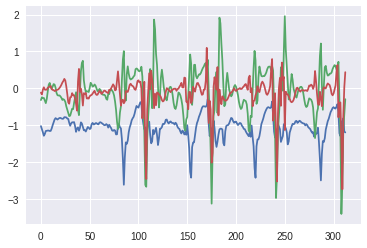

In [12]:
ax=plt.plot(data.anterior_thigh__accel.iloc[0][:,:3])

## Unilateral

In [11]:
len(data)

48568

In [12]:
data.Visit.unique()

array(['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60',
       '2 Weeks: Time 90', '2 Weeks: Time 120', '2 Weeks: Time 150',
       '4 Weeks'], dtype=object)

In [13]:
data=data.reset_index(drop=True)

In [14]:
#remove rows where some sensors have empty clips
for s in data.columns[7:].values:
    print(s,sum(data[s].apply(type) == float))
    indempty = data[s].apply(type) == float
    data = data[~indempty]
    
print(len(data))

anterior_thigh__accel 267
anterior_thigh__gyro 0
distal_lateral_shank__accel 62
distal_lateral_shank__gyro 0
dorsal_hand__accel 2
dorsal_hand__gyro 0
flexor_digitorum__accel 612
medial_chest_accel 7
sacrum_accel 0
sacrum_gyro 0
47618


In [15]:
#remove nans
for s in data.columns[7:].values:
    inds=data[s].apply(len) == 1
    data = data[~inds]
print(len(data))

41219


In [16]:
print(len(data))
for s in data.columns[7:].values:
    print(s)
    print(data[s].apply(len).unique()) #sanity check

41219
anterior_thigh__accel
[313]
anterior_thigh__gyro
[313]
distal_lateral_shank__accel
[313]
distal_lateral_shank__gyro
[313]
dorsal_hand__accel
[313]
dorsal_hand__gyro
[313]
flexor_digitorum__accel
[313]
medial_chest_accel
[313]
sacrum_accel
[313]
sacrum_gyro
[313]


In [17]:
#drop time column from array data
for s in data.columns[7:].values:
    data[s]=data[s].apply(lambda x: x[:,:-1])
    print(data[s].apply(lambda x: x.shape).unique())

[(313, 3)]
[(313, 3)]
[(313, 3)]
[(313, 3)]
[(313, 3)]
[(313, 3)]
[(313, 3)]
[(313, 3)]
[(313, 3)]
[(313, 3)]


In [18]:
datacopy=data.copy()

In [19]:
data=datacopy.copy()

In [22]:
data.Subject.unique()

array([1004, 1016, 1018, 1019, 1020, 1024, 1029, 1030, 1032, 1038, 1044,
       1046, 1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

In [23]:
# data[data.Dyskinesia >0].Task.unique()

In [42]:
#get rid of subj 1020 and of 1M of data in subj 1004
data = data.loc[data.Subject!=1020]

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: Mean of empty slice


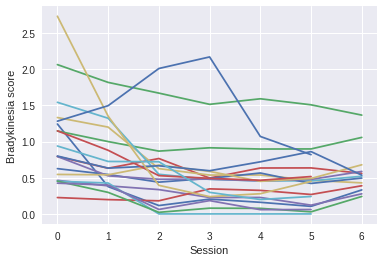

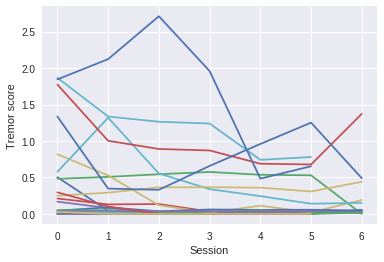

In [25]:
plt.figure()
for s in data.Subject.unique():
#     print(s,len(data[data.Subject==s].Visit.unique()))
    score = []
    for v in data.loc[data.Subject==s,'Visit'].unique():
        score.append(np.nanmean(data.loc[(data.Subject==s)&(data.Visit==v),'Bradykinesia'].values))
    
    plt.plot(score)

plt.xlabel('Session')
plt.ylabel('Bradykinesia score')

plt.figure()
for s in data.Subject.unique():
#     print(s,len(data[data.Subject==s].Visit.unique()))
    score = []
    for v in data.loc[data.Subject==s,'Visit'].unique():
        score.append(np.nanmean(data.loc[(data.Subject==s)&(data.Visit==v),'Tremor'].values))
    
    plt.plot(score)

plt.xlabel('Session')
plt.ylabel('Tremor score')


In [131]:
# #mean and max Nsamples for each sensors
# mean_samples = []; max_samples=[]
# for s in data.columns[7:].values:
#     mean_samples.append(data[s].apply(len).mean())
#     max_samples.append(data[s].apply(len).max())
#     print(s,max_samples[-1],mean_samples[-1])

### Standardize data

In [24]:
data.shape

(39505, 17)

In [25]:
data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,distal_lateral_shank__accel,distal_lateral_shank__gyro,dorsal_hand__accel,dorsal_hand__gyro,flexor_digitorum__accel,medial_chest_accel,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-1.0221713588158998, -0.3163500419623104, -0...","[[78.5229266803999, -34.94316014343485, -75.77...","[[-1.07173266193637, -0.09893949797817968, -0....","[[22.61387045090396, -15.960936903944454, 45.0...","[[0.38654154268711416, -0.98970016021973, 0.21...","[[2.410925459678083, 28.71747920958251, 1.8005...","[[-0.9848172732127872, 0.35846494239719195, -0...","[[-0.02337682154573884, 0.9190203707942324, 0....","[[0.06939803158617508, 1.017288471808957, 0.02...","[[-7.660028992141633, -6.195162890058782, 2.47..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-1.4605325398641948, 0.6361791409170676, -0....","[[-121.79751277943092, -0.6408789196611906, -1...","[[-0.39313344014648655, -0.6288548104066529, -...","[[0.6408789196611906, -14.373998626688035, 126...","[[-0.03558403906309593, -1.087968261234455, 0....","[[-54.41367208361953, 12.970168612191856, 110....","[[-0.803662165255207, 0.2485999847409781, -0.1...","[[-0.05853360799572727, 1.0484168764782176, 0....","[[0.05792324711985941, 1.2392156862745098, 0.2...","[[-5.645838101777599, 17.975127794308268, 9.36..."


In [26]:
data.columns[7:]

Index(['anterior_thigh__accel', 'anterior_thigh__gyro',
       'distal_lateral_shank__accel', 'distal_lateral_shank__gyro',
       'dorsal_hand__accel', 'dorsal_hand__gyro', 'flexor_digitorum__accel',
       'medial_chest_accel', 'sacrum_accel', 'sacrum_gyro'],
      dtype='object')

In [27]:
#use only 3 sensors
# data=data.drop(['distal_lateral_shank__accel','distal_lateral_shank__gyro','flexor_digitorum__accel','medial_chest_accel'],axis=1)

In [28]:
def maxarr(arr):
    m=max(np.max(arr[:,:-1],axis=0))
    return m

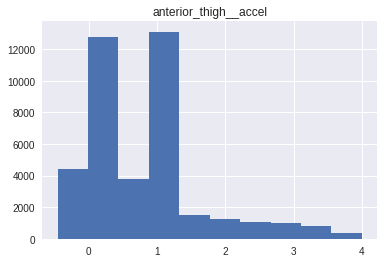

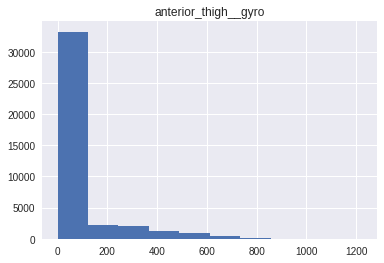

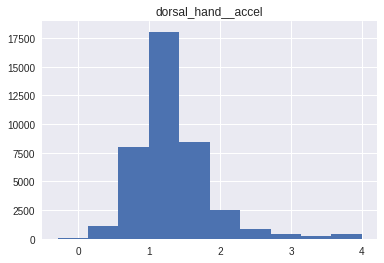

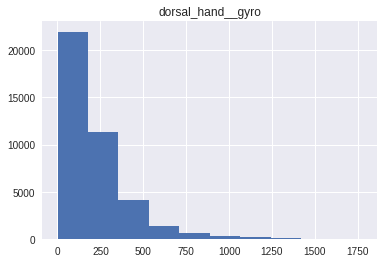

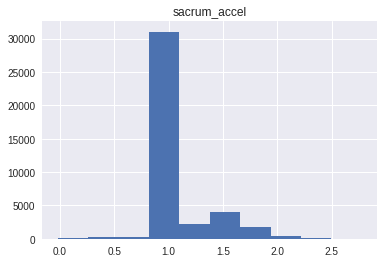

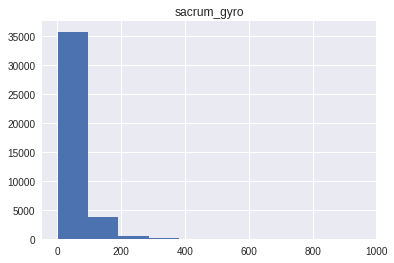

In [33]:
#plot distribution of maximum values for each sensor
for s in data.columns[7:].values:
    xm=(data[s].apply(maxarr))
    plt.figure()
    plt.title(s)
    plt.hist(xm)

### The effect of different type of normalizations

In [29]:
#reshape data
s='dorsal_hand__accel'
ns=313
a = np.empty((len(data),ns,3))
for i in range(len(data[s])):
    a[i,:,:]=data[s].values[i] #(clip,time,channel)
print(a.shape)

(39505, 313, 3)


In [30]:
an=stdclipdata(a) #center by mean and normalize by std

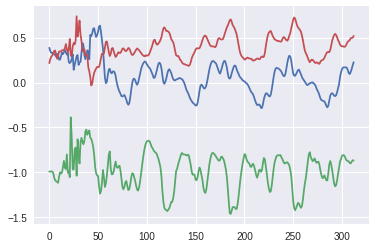

In [31]:
ax=plt.plot(a[0]) #original clip

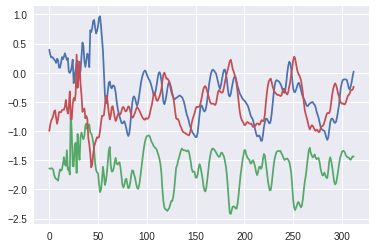

In [32]:
an = stdclipdata(a)
ax=plt.plot(an[0]) #centered and normalized by std dev

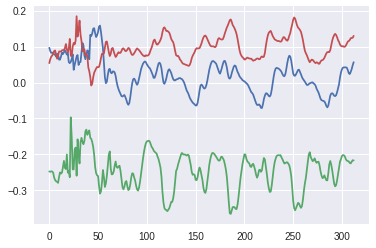

In [33]:
an = stdclipdata(a,normtype='max')
ax=plt.plot(an[0]) #normalized by max value

In [34]:
#create data structure for network and normalize clips by maximum value for each channel
X = {}
ns = 313
arr=np.empty([])
for s in data.columns[7:].values:
    a = np.empty((len(data),ns,3))
    for i in range(len(data[s])):
        a[i,:,:]=data[s].values[i] #(clip,time,channel)
            
    #normalize by relative order of magnitude of gyro vs. accel data
#     if s.find('gyro') > 0:
#         a=a/100
    
    #normalize clips data
    an = stdclipdata(a,normtype='center')
    print(s,an.shape)
    #concatenate data from all locations (3rd axis)
    if arr.size == 1:
        arr = an.copy()
    else:
        arr = np.concatenate((arr,an),axis=-1)
    
X['data']=arr
X['sensor']=data.columns[7:]

anterior_thigh__accel (39505, 313, 3)
anterior_thigh__gyro (39505, 313, 3)
distal_lateral_shank__accel (39505, 313, 3)
distal_lateral_shank__gyro (39505, 313, 3)
dorsal_hand__accel (39505, 313, 3)
dorsal_hand__gyro (39505, 313, 3)
flexor_digitorum__accel (39505, 313, 3)
medial_chest_accel (39505, 313, 3)
sacrum_accel (39505, 313, 3)
sacrum_gyro (39505, 313, 3)


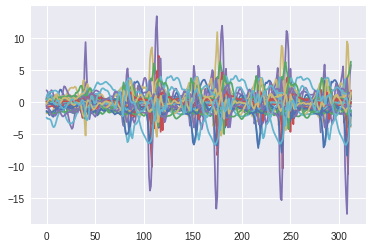

In [35]:
ax=plt.plot(X['data'][0]) #clip 0 from all sensors - normalized 

In [36]:
X['data'].shape

(39505, 313, 30)

In [37]:
Xall=X.copy()

## Assemble and save data for Bradykinesia and Tremor classification

In [44]:
le = LabelEncoder()
taskcodes = le.fit_transform(data.Task)
taskcodes = np.unique(taskcodes)
tasknames = le.inverse_transform(taskcodes)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [45]:
task = le.fit_transform(data.Task)
np.unique(task)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [46]:
task = le.fit_transform(data.Task)

In [47]:
l = list(zip(taskcodes,tasknames))

In [43]:
#numerical encoding of metadata
le = LabelEncoder()
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)

#remove rows (tasks) for which bradykinesia scores do not exists
y = data.Bradykinesia.values
indok = np.where(~np.isnan(y))[0]
X = Xall['data'][indok,:,:]
y = y[indok]
print(X.shape,y.shape)
Data_brady={'X':X,'y':y,'task':task[indok],'visit':visit[indok],'subj':subj[indok],'sensor':data.columns[7:]}

#remove rows (tasks) for which tremor scores do not exists
y = data.Tremor.values
indok = np.where(~np.isnan(y))[0]
X = Xall['data'][indok,:,:]
y = y[indok]
print(X.shape,y.shape)
Data_tremor={'X':X,'y':y,'task':task[indok],'visit':visit[indok],'subj':subj[indok],'sensor':data.columns[7:]}

(31582, 313, 30) (31582,)
(37571, 313, 30) (37571,)


In [44]:
#save data
filename = 'ClipsBrady.pkl'
f = open(os.path.join(features_path,filename),'wb')
pickle.dump(Data_brady,f)
f.close()

filename = 'ClipsTremor.pkl'
f = open(os.path.join(features_path,filename),'wb')
pickle.dump(Data_tremor,f)
f.close()

Train CNN using LOSO CV

## Train CNN

In [16]:
#load data
filename = 'ClipsBrady.pkl'
f = open(os.path.join(features_path,filename),'rb')
Data_brady = pickle.load(f)
f.close()
#assemble
X = Data_brady['X']
y = Data_brady['y']
task = Data_brady['task']
visit = Data_brady['visit']
subj = Data_brady['subj']
print(X.shape)
print(y.shape)
print(np.unique(task))
print(np.unique(visit))
print(np.unique(subj))
#binarize labels
y[y>0] = 1

(31582, 313, 30)
(31582,)
[ 0  1  2  5  6  7  8 10 11 12]
[0 1 2 3 4 5 6]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [14]:
#load data
filename = 'ClipsTremor.pkl'
f = open(os.path.join(features_path,filename),'rb')
Data_tremor = pickle.load(f)
f.close()
#assemble
X = Data_tremor['X']
y = Data_tremor['y']
task = Data_tremor['task']
visit = Data_tremor['visit']
subj = Data_tremor['subj']
print(X.shape)
print(y.shape)
print(np.unique(task))
print(np.unique(visit))
print(np.unique(subj))
#binarize labels
y[y>0] = 1

(37571, 313, 30)
(37571,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[0 1 2 3 4 5 6]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [15]:
Data_tremor['sensor']

Index(['anterior_thigh__accel', 'anterior_thigh__gyro',
       'distal_lateral_shank__accel', 'distal_lateral_shank__gyro',
       'dorsal_hand__accel', 'dorsal_hand__gyro', 'flexor_digitorum__accel',
       'medial_chest_accel', 'sacrum_accel', 'sacrum_gyro'],
      dtype='object')

In [21]:
Data_brady['sensor']

Index(['anterior_thigh__accel', 'anterior_thigh__gyro',
       'distal_lateral_shank__accel', 'distal_lateral_shank__gyro',
       'dorsal_hand__accel', 'dorsal_hand__gyro', 'flexor_digitorum__accel',
       'medial_chest_accel', 'sacrum_accel', 'sacrum_gyro'],
      dtype='object')

In [57]:
Xorig = X.copy()
# X = X[:,:,6:12]
X = X[:,:,12:18]
X.shape

(31582, 313, 0)

**Data Augmentation Class**

In [17]:
#rotate vector p around axis (0=x, 1=y, 2=z(orthogonal to sensor plane))
#vector p is 3x1"
def rot(th,p,axis=2):
    if axis == 0: #x-axis rot
        R = np.array([[1,0,0],[0, np.cos(th), -np.sin(th)],[0, np.sin(th), np.cos(th)]])
    if axis ==1: #y-axis rot
        R = np.array([[np.cos(th), 0, np.sin(th)],[0,1,0],[-np.sin(th), 0, np.cos(th)]])    
    if axis==2: #z-axis rot
        R = np.array([[np.cos(th), -np.sin(th), 0],[np.sin(th), np.cos(th), 0],[0,0,1]])

    pR = np.matmul(R,p)
    return pR,R

In [18]:
X.shape

(31582, 313, 30)

In [26]:
# xR_all.shape

In [162]:
# Xaug = np.empty((100,1,313,30))
# xR_all = np.empty((1,313,30))
# ID = 0; th=np.pi/4; rax=0
# for c in range(X_train.shape[-1]//3):
#     xR = rot(th,X_train[ID,:,:,c*3:(c+1)*3].squeeze().T,axis=rax)[0].T
#     print(xR.shape)
#     xR_all[:,:,c*3:(c+1)*3] = np.expand_dims(xR,axis=0)

# print(xR_all.shape)
# Xaug[ID,:,:,:] = xR_all


In [19]:
#create Data Generator Class to apply random rotations to training data

class DataGenerator(object):

    #class init fcn
    def __init__(self, dim_x = 1, dim_y=313, dim_z = 30, batch_size=512, shuffle=True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size= batch_size
        self.shuffle = shuffle
    
    #Acutal generator method. Its structure is an infinite loop that goes through the dataset 
    #and outputs one batch at a time.
    def generate(self, X_train, labels):
         # Infinite loop
        while 1:
            # Generate batches
            indexes = np.arange(len(labels))
            #shuffle data
            if self.shuffle == True:
                np.random.shuffle(indexes)
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                #Find list of IDs for current batch
                list_IDs_temp = [indexes[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                #generate data (rotated)
                X,y = self.__data_generation(X_train,labels,list_IDs_temp)

                yield X,y


    #Private method: generates a random order of exploration for a given set of list_IDs (train indices)    
    def __get_exploration_order(self, list_IDs):
        '  Find exploration order'
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)

        return indexes


    #outputs batches of data. The private method in charge of this task is called __data_generation and
    #only needs to know about the list of IDs included in batches as well as their corresponding labels.
    def __data_generation(self, X_train, labels, list_IDs_temp):
        num_classes = 2
        'Generates data of batch_size samples' # X : (n_samples, 1, time, n_channels)
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        y = np.empty((self.batch_size), dtype=int)

        #generate data
        for i, ID in enumerate(list_IDs_temp):
            
            #store batch data - DO NOT AUGMENT - FOR DEBUG ONLY
#             X[i,:,:,:] = X_train[ID,:,:,:]

            #random rotation for current batch
            
            #rotate data from each sensor (3 axis)
            xR_all = np.empty((1,self.dim_y,self.dim_z))
            for c in range(X_train.shape[-1]//3):
                rax = np.random.randint(0,3) #select random axis to rotate around
                a = 5; b = 5 #min,max rotation (degrees)
                th=((b-a)*np.random.rand(1)+a)[0] #pick random angle
                th = np.pi*th/180
                xR = rot(th,X_train[ID,:,:,c*3:(c+1)*3].squeeze().T,axis=rax)[0].T
                xR_all[:,:,c*3:(c+1)*3] = np.expand_dims(xR,axis=0)
                            
            X[i,:,:,:] = xR_all
            
            #generate new clip by overlapping 2 consecutive clips (shuffle must be set to False)
            if self.shuffle == False:
                x0 = X[i-1,:,:,:]
                x1 = X[i,:,:,:]
                x = np.concatenate((x0,x1),axis=1)
                ind0 = int((0.5*np.random.rand(1)+0.25)*self.dim_y) #pick random start time in clip 0
                Xnew = x[:,ind0:ind0+self.dim_y] 
                X[i,:,:,:] = Xnew
            
            #multiplicative noise (scaling)
            X[i,:,:,:] = X[i,:,:,:]*(1+0.05*np.random.randn(1)[0])

            #store labels
            y[i] = labels[ID]

        return X, keras.utils.to_categorical(y,num_classes)




#  LOSO CV 

In [57]:
Data_brady['sensor']

Index(['anterior_thigh__accel', 'anterior_thigh__gyro',
       'distal_lateral_shank__accel', 'distal_lateral_shank__gyro',
       'dorsal_hand__accel', 'dorsal_hand__gyro', 'flexor_digitorum__accel',
       'medial_chest_accel', 'sacrum_accel', 'sacrum_gyro'],
      dtype='object')

In [58]:
Xorig = X.copy()
print(Xorig.shape)

(31582, 313, 30)


In [50]:
# X = Xorig[:,:,6:12].copy()
X = Xorig[:,:,0:6].copy() #thigh
# X = Xorig[:,:,6:12].copy() #shank
# X = Xorig[:,:,12:18].copy() #hands
# X = Xorig[:,:,18:21].copy() #arm
# X = Xorig[:,:,21:24].copy() #chest
# X = X[:,:,24:30] #sacrum

#3 sensors
# X = np.concatenate((Xorig[:,:,:6],Xorig[:,:,12:18],Xorig[:,:,21:24]),axis=2)

X.shape

(31582, 313, 6)

reshaping data for different models ...
CNN
X_train = 
(29994, 1, 313, 15)
model training ... - eval on visit [0]
Epoch 1/30
58/58 [==============================] - 8s - loss: 0.6855 - acc: 0.5409 - val_loss: 0.6831 - val_acc: 0.5334
Epoch 2/30
58/58 [==============================] - 8s - loss: 0.6301 - acc: 0.6263 - val_loss: 0.6340 - val_acc: 0.6360
Epoch 3/30
58/58 [==============================] - 8s - loss: 0.5689 - acc: 0.7041 - val_loss: 0.6057 - val_acc: 0.6902
Epoch 4/30
58/58 [==============================] - 8s - loss: 0.5075 - acc: 0.7492 - val_loss: 0.6683 - val_acc: 0.7103
Epoch 5/30
58/58 [==============================] - 8s - loss: 0.4788 - acc: 0.7682 - val_loss: 0.7378 - val_acc: 0.6499
Epoch 6/30
58/58 [==============================] - 8s - loss: 0.4629 - acc: 0.7777 - val_loss: 0.7206 - val_acc: 0.6845
Epoch 7/30
58/58 [==============================] - 8s - loss: 0.4349 - acc: 0.7972 - val_loss: 0.7481 - val_acc: 0.6694
Epoch 8/30
58/58 [=====================

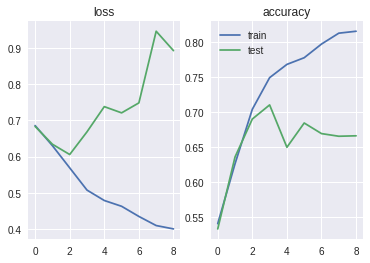

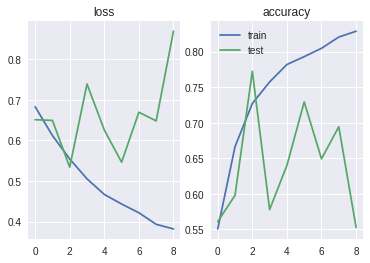

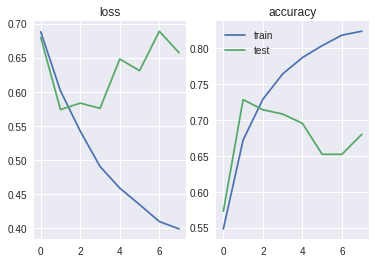

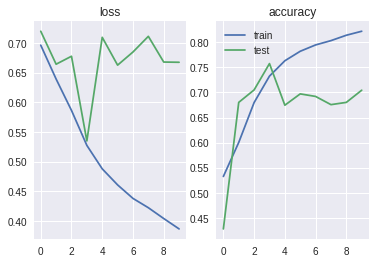

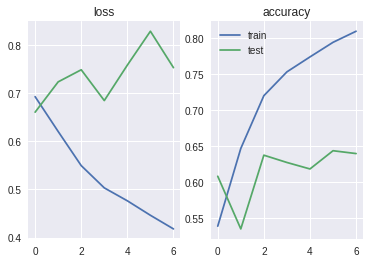

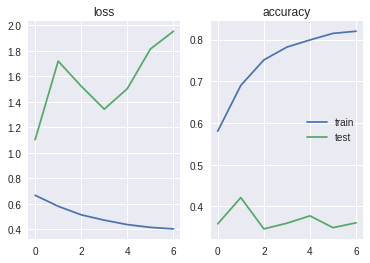

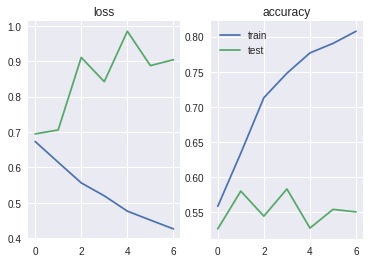

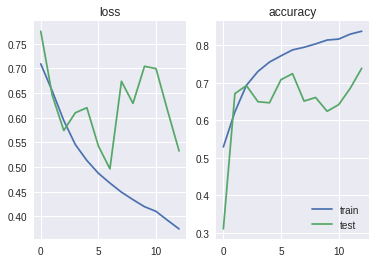

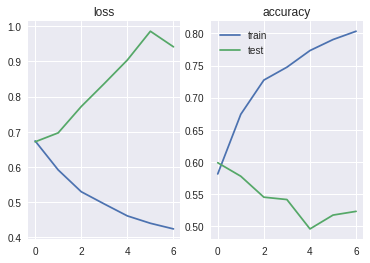

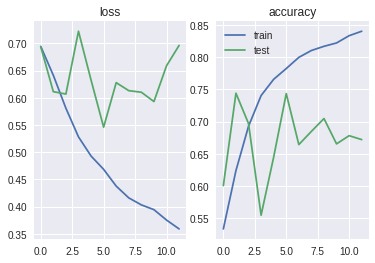

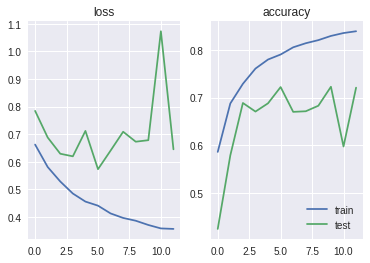

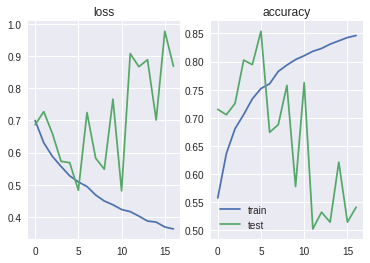

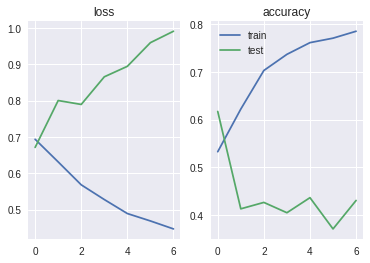

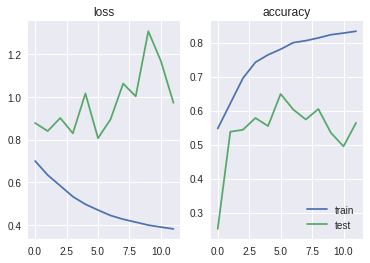

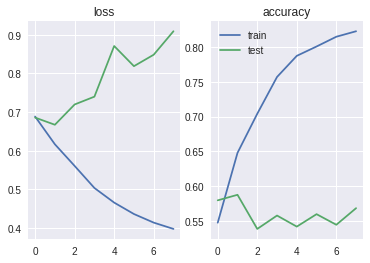

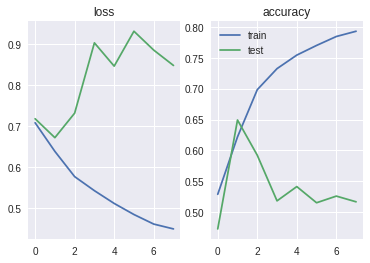

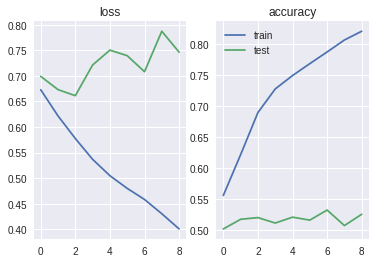

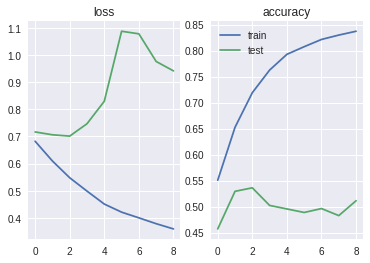

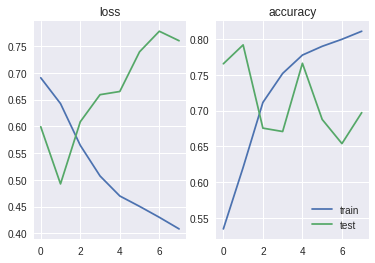

In [108]:
#specify loso or lovo cv
# lovar = visit.copy()
lovar = subj.copy()

#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, lovar):
    
    RecS=[] #store recall per task
    
    current_visit = np.unique(lovar[test_index])
    task_subj = task[test_index] #tasks for current visit

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
#     y_train = keras.utils.to_categorical(y_train, num_classes) #not needed for data augmentation
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on visit %s'%current_visit)
    epochs = 30
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
    callbacks_list = [earlystop]

    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    #Initialize DataGenerator object
    trainIDs = list(np.arange(X_train.shape[0]))
    training_generator = DataGenerator(dim_z=X_train.shape[-1],shuffle=True).generate(X_train,y_train)

    hist=model.fit_generator(generator=training_generator, epochs=epochs, steps_per_epoch=len(trainIDs)//batch_size,
                            validation_data=(X_valid,y_valid),verbose=1,callbacks=callbacks_list)

    #metrics
    f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    rec_all.append(Rec)
    spec_all.append(Spec)
    fpr_all.append(fpr); tpr_all.append(tpr)
    
    #store recall per task
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_valid = np.argmax(y_valid,axis=1)
    for t in np.unique(task_subj):
        
        ind_task = task_subj==t
        ypred_s = y_pred[ind_task]
        ytrue_s = y_valid[ind_task]
        TP=sum(ypred_s[ytrue_s==1])
        P = sum(ytrue_s == 1)
        RecS.append(TP/P)
        
    rec_task[current_visit[0]]=np.asarray(RecS)


        

In [89]:
data.Subject.unique()

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


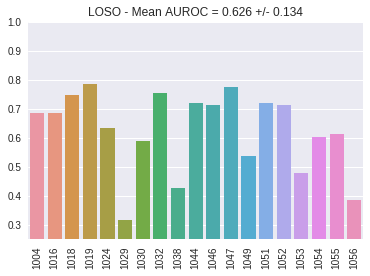

In [137]:
# aurocall = Results['auroc']
sns.barplot(data.Subject.unique(),aurocall) #to show subj codes
plt.ylim([0.25,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
ax=plt.xticks(rotation=90)

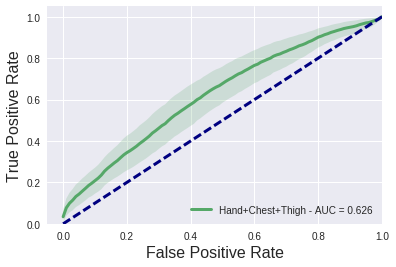

In [161]:
current_palette=sns.color_palette()

AX=plot_roc(Results['TPR'],Results['FPR'][0],np.mean(aurocall),ax=None,plotname='Hand+Chest+Thigh',col=current_palette[1])
# AX=plot_roc(Results['TPR'],Results['FPR'][0],np.mean(aurocall),ax=None,plotname='Hand',col=current_palette[1])
# AX=plot_roc(Results['TPR'],Results['FPR'][0],np.mean(aurocall),ax=None,plotname='Thigh',col=current_palette[1])

# plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

In [129]:
Results = {'f1':f1all, 'recall':rec_all, 'spec':spec_all, 'auroc':aurocall, 'auprc':auprcall, 'rec_task':rec_task,
          'TPR':tpr_all,'FPR':fpr_all}
np.save('./Results/Brady_LOSO_3Sensors.npy',Results)

In [163]:
# Results=np.load('./Results/Brady_LOVO_Chest.npy')
# Results=np.load('./Results/Brady_LOVO_Hands.npy')
Results=np.load('./Results/Brady_LOSO_3Sensors.npy')
Results = Results.item()

In [165]:
Results['auroc']
# rec_task = Results['rec_task']

[0.6858302363715781,
 0.6849031237643339,
 0.7480956799138617,
 0.7867700787401574,
 0.6323803021136689,
 0.31703543996197936,
 0.5882873670678976,
 0.7562326052606585,
 0.42817482602184637,
 0.7205639215062383,
 0.711685769864854,
 0.7746232930466175,
 0.5374322057590158,
 0.7210897178353989,
 0.712070697925432,
 0.4798062342641337,
 0.602199413489736,
 0.6123385386543282,
 0.38612441354498384]

In [ ]:
#add names to task recall dataframe
le = LabelEncoder()
taskcodes = le.fit_transform(np.unique(data.Task))
tasknames = le.inverse_transform(np.unique(Data_brady['task']))
rec_task.index = tasknames

In [83]:
rec_task

""


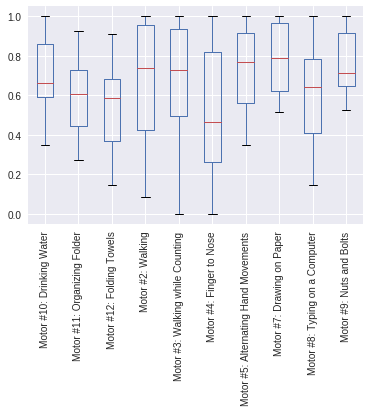

In [55]:
#old style
rec_task.T.plot(kind='box')
ax=plt.xticks(rotation=90)

## Leave one visit out CV 

In [61]:
Data_brady['sensor']

Index(['anterior_thigh__accel', 'anterior_thigh__gyro',
       'distal_lateral_shank__accel', 'distal_lateral_shank__gyro',
       'dorsal_hand__accel', 'dorsal_hand__gyro', 'flexor_digitorum__accel',
       'medial_chest_accel', 'sacrum_accel', 'sacrum_gyro'],
      dtype='object')

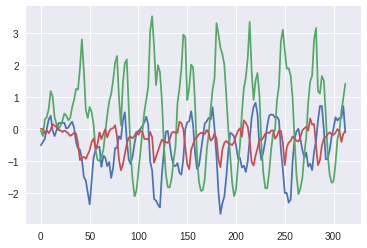

In [71]:
ax=plt.plot(Data_brady['X'][0,:,21:24])

In [20]:
Xorig = X.copy()
print(Xorig.shape)

(37571, 313, 30)


In [56]:
Xorig.shape

NameError: name 'Xorig' is not defined

In [38]:
# X = Xorig[:,:,6:12].copy()
# X = Xorig[:,:,0:6].copy() #thigh
# X = Xorig[:,:,6:12].copy() #shank
# X = Xorig[:,:,12:18].copy() #hands
X = Xorig[:,:,18:21].copy() #arm
# X = Xorig[:,:,21:24].copy() #chest
# X = X[:,:,24:30] #sacrum

X.shape

(37571, 313, 3)

reshaping data for different models ...
CNN
X_train = 
(31529, 1, 313, 3)
model training ... - eval on visit [0]
Epoch 1/30
61/61 [==============================] - 2s - loss: 0.5476 - acc: 0.7667 - val_loss: 0.6609 - val_acc: 0.6504
Epoch 2/30
61/61 [==============================] - 2s - loss: 0.4943 - acc: 0.7929 - val_loss: 0.6219 - val_acc: 0.6504
Epoch 3/30
61/61 [==============================] - 2s - loss: 0.4756 - acc: 0.7927 - val_loss: 0.6152 - val_acc: 0.6504
Epoch 4/30
61/61 [==============================] - 2s - loss: 0.4498 - acc: 0.7954 - val_loss: 0.6030 - val_acc: 0.6528
Epoch 5/30
61/61 [==============================] - 2s - loss: 0.4379 - acc: 0.7991 - val_loss: 0.5879 - val_acc: 0.6855
Epoch 6/30
61/61 [==============================] - 2s - loss: 0.4259 - acc: 0.8071 - val_loss: 0.5588 - val_acc: 0.6975
Epoch 7/30
61/61 [==============================] - 2s - loss: 0.4124 - acc: 0.8137 - val_loss: 0.5628 - val_acc: 0.7287
Epoch 8/30
61/61 [======================

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


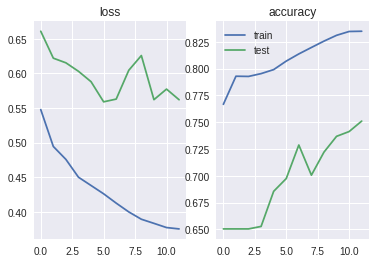

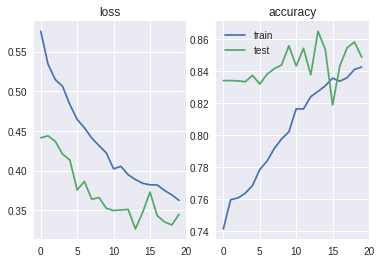

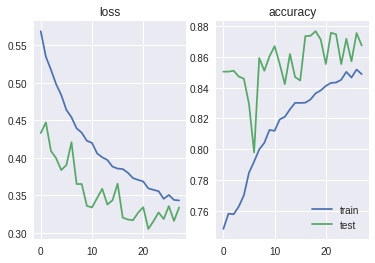

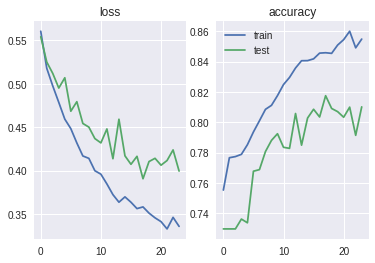

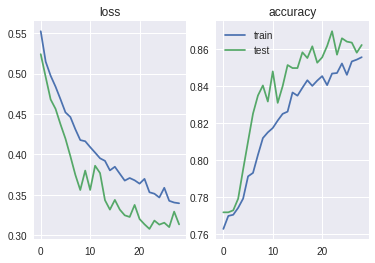

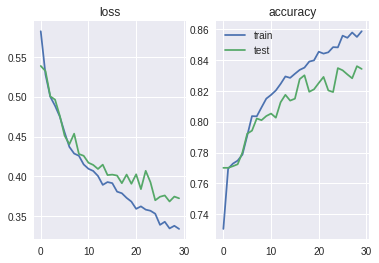

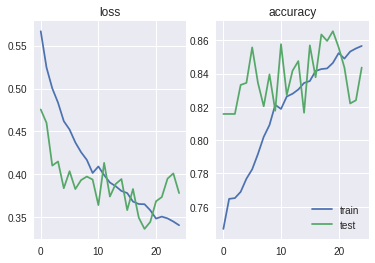

In [39]:
#specify loso or lovo cv
lovar = visit.copy()
# lovar = subj.copy()

#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, lovar):
    
    RecS=[] #store recall per task
    
    current_visit = np.unique(lovar[test_index])
    task_subj = task[test_index] #tasks for current visit

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
#     y_train = keras.utils.to_categorical(y_train, num_classes) #not needed for data augmentation
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on visit %s'%current_visit)
    epochs = 30
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
    callbacks_list = [earlystop]

    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    #Initialize DataGenerator object
    trainIDs = list(np.arange(X_train.shape[0]))
    training_generator = DataGenerator(dim_z=X_train.shape[-1],shuffle=True).generate(X_train,y_train)

    hist=model.fit_generator(generator=training_generator, epochs=epochs, steps_per_epoch=len(trainIDs)//batch_size,
                            validation_data=(X_valid,y_valid),verbose=1,callbacks=callbacks_list)

    #metrics
    f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    rec_all.append(Rec)
    spec_all.append(Spec)
    fpr_all.append(fpr); tpr_all.append(tpr)
    
    #store recall per task
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_valid = np.argmax(y_valid,axis=1)
    for t in np.unique(task_subj):
        
        ind_task = task_subj==t
        ypred_s = y_pred[ind_task]
        ytrue_s = y_valid[ind_task]
        TP=sum(ypred_s[ytrue_s==1])
        P = sum(ytrue_s == 1)
        RecS.append(TP/P)
        
    rec_task[current_visit[0]]=np.asarray(RecS)

#add names to task recall dataframe
taskcodes = le.fit_transform(np.unique(data.Task))
tasknames = le.inverse_transform(np.unique(task_subj))
rec_task.index = tasknames
        

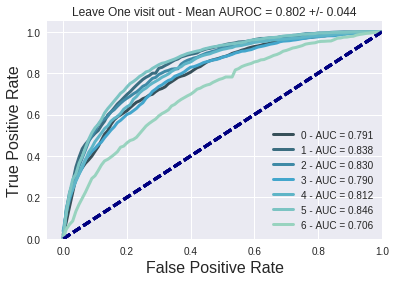

In [105]:
#using 1 sensors (hand)
# current_palette=sns.color_palette("Paired", len(aurocall))
# current_palette=sns.color_palette("Reds", len(aurocall))
current_palette=sns.color_palette("GnBu_d", len(aurocall))

for v in range(len(aurocall)):
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

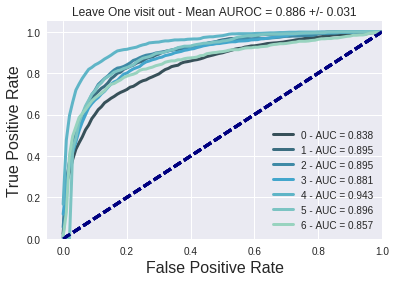

In [30]:
#tremor
#using 1 sensors (hand)
current_palette=sns.color_palette("GnBu_d", len(aurocall))

for v in range(len(aurocall)):
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

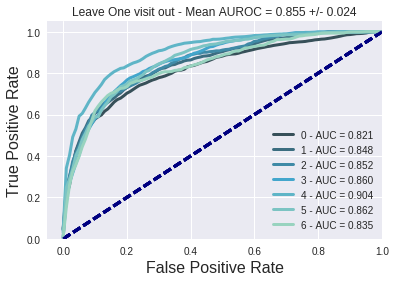

In [40]:
#tremor
#using 1 sensors (arms)
current_palette=sns.color_palette("GnBu_d", len(aurocall))

for v in range(len(aurocall)):
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

In [41]:
Results = {'f1':f1all, 'recall':rec_all, 'spec':spec_all, 'auroc':aurocall, 'auprc':auprcall, 'rec_task':rec_task,
          'TPR':tpr_all,'FPR':fpr_all}
np.save('./Results/Tremor_LOVO_Arms.npy',Results)

In [42]:
# Results=np.load('./Results/Brady_LOVO_Chest.npy')
Results=np.load('./Results/Tremor_LOVO_Arms.npy')

In [43]:
rec_task = Results.item()['rec_task']

In [44]:
#add names to task recall dataframe
taskcodes = le.fit_transform(np.unique(data.Task))
tasknames = le.inverse_transform(np.unique(task_subj))
rec_task.index = tasknames

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [45]:
rec_task

,0,1,2,3,4,5,6
Motor #10: Drinking Water,0.294118,0.495798,0.645161,0.370558,0.559441,0.362416,0.591837
Motor #11: Organizing Folder,0.250000,0.543478,0.427083,0.521053,0.470588,0.415493,0.538462
Motor #12: Folding Towels,0.329609,0.584416,0.666667,0.462406,0.705882,0.523364,0.740506
Motor #13: Sitting,0.271186,1.000000,0.000000,0.360000,0.925926,0.702703,0.933333
Motor #1: Standing,0.348485,0.200000,0.354167,0.293333,0.458333,0.216216,0.080000
Motor #2: Walking,0.673913,0.956522,0.783784,0.819672,0.703125,0.863636,0.480000
Motor #3: Walking while Counting,0.768421,0.913793,0.661765,0.893333,0.902174,0.888889,0.500000
Motor #4: Finger to Nose,0.401361,0.800000,0.536232,0.567308,0.689189,0.472527,0.635135
Motor #5: Alternating Hand Movements,0.325203,0.654321,0.763158,0.630952,0.625000,0.765432,0.853659
Motor #6: Sit to Stand,0.121951,0.000000,0.333333,0.346154,0.500000,0.416667,NaN


/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


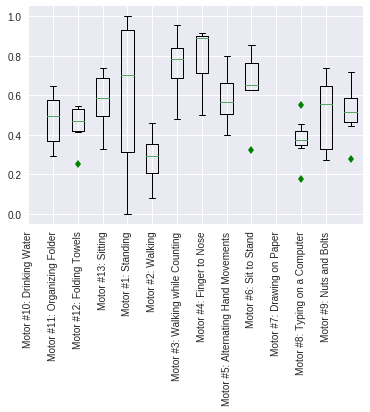

In [46]:
ax=plt.boxplot(rec_task.T.values,0,'gd')
ax=plt.xticks(np.arange(len(rec_task)),rec_task.index,rotation=90)

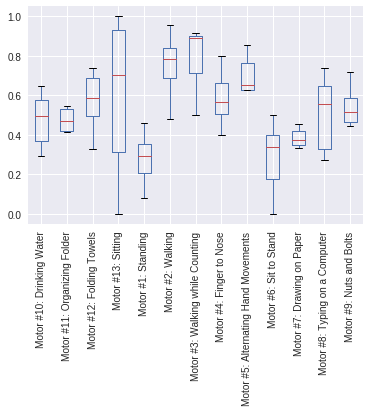

In [47]:
#old style
rec_task.T.plot(kind='box')
ax=plt.xticks(rotation=90)

In [99]:
print(np.mean(Results.item()['recall']),np.std(Results.item()['recall']))

0.5891176783458351 0.1323036487701528


In [230]:
print(np.mean(Results.item()['spec']),np.std(Results.item()['spec']))

0.7081481159239351 0.040813531537583866


In [231]:
print(np.mean(Results.item()['auroc']),np.std(Results.item()['auroc']))

0.8026247107493708 0.040504687098061785


* Overfitting occurs with increased number of filters. Optimal is ~16 in layer 1 and 32 in layer 2. 
* Using all locations improves performance on first sessions (Overfitting) but not significantlt on last session - poor generalization.
* However, this data lacks finger to nose and alternating hand tasks; plus it lacks overlapping windows (i.e. additional data points) - (there are less than half clips than in the test with 2 locations). 
* Normalizing the input raw sensors data by the maximum value across the 3 channels rather than by centering seems to improve performance

## All sensors

In [235]:
X = Xorig.copy()
print(X.shape)

(32156, 313, 18)


reshaping data for different models ...
CNN
X_train = 
(27018, 1, 313, 18)
model training ... - eval on visit [0]
Epoch 1/30
52/52 [==============================] - 8s - loss: 0.6707 - acc: 0.5726 - val_loss: 0.6479 - val_acc: 0.6596
Epoch 2/30
52/52 [==============================] - 8s - loss: 0.5952 - acc: 0.6927 - val_loss: 0.5473 - val_acc: 0.7118
Epoch 3/30
52/52 [==============================] - 8s - loss: 0.5520 - acc: 0.7282 - val_loss: 0.5507 - val_acc: 0.7028
Epoch 4/30
52/52 [==============================] - 8s - loss: 0.5166 - acc: 0.7494 - val_loss: 0.5624 - val_acc: 0.6972
Epoch 5/30
52/52 [==============================] - 8s - loss: 0.4920 - acc: 0.7660 - val_loss: 0.5574 - val_acc: 0.7110
Epoch 6/30
52/52 [==============================] - 8s - loss: 0.4728 - acc: 0.7788 - val_loss: 0.5804 - val_acc: 0.6900
Epoch 7/30
52/52 [==============================] - 8s - loss: 0.4547 - acc: 0.7819 - val_loss: 0.5548 - val_acc: 0.7306
Epoch 8/30
52/52 [=====================

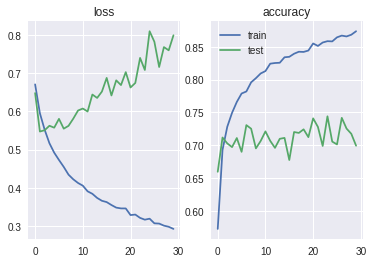

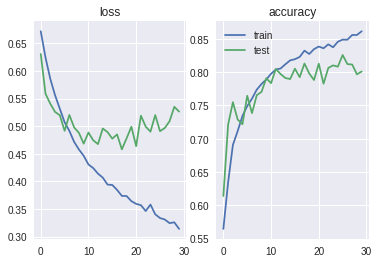

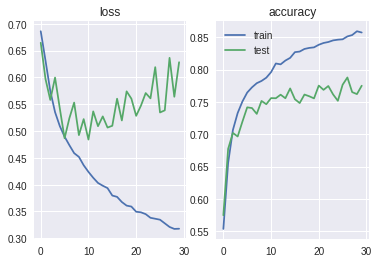

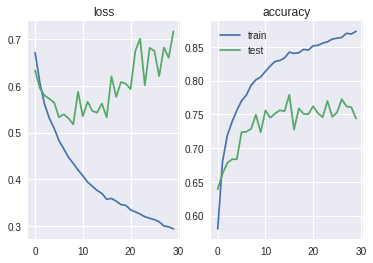

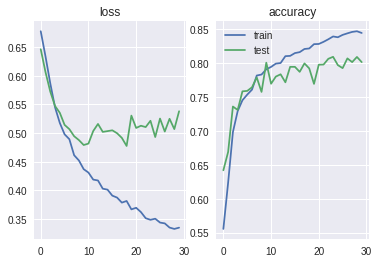

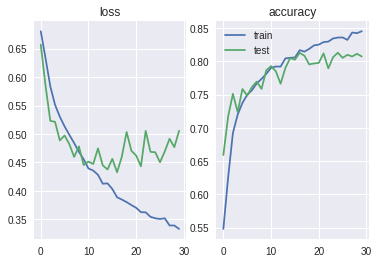

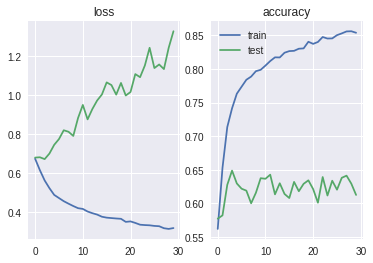

In [238]:
#specify loso or lovo cv
lovar = visit.copy()
# lovar = subj.copy()

#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, lovar):
    
    RecS=[] #store recall per task
    
    current_visit = np.unique(lovar[test_index])
    task_subj = task[test_index] #tasks for current visit

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
#     y_train = keras.utils.to_categorical(y_train, num_classes) #not needed for data augmentation
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on visit %s'%current_visit)
    epochs = 30
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    #Initialize DataGenerator object
    trainIDs = list(np.arange(X_train.shape[0]))
    training_generator = DataGenerator(dim_z=X_train.shape[-1],shuffle=True).generate(X_train,y_train)

    hist=model.fit_generator(generator=training_generator, epochs=epochs, steps_per_epoch=len(trainIDs)//batch_size,
                            validation_data=(X_valid,y_valid),verbose=1)

    #metrics
    f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    rec_all.append(Rec)
    spec_all.append(Spec)
    fpr_all.append(fpr); tpr_all.append(tpr)
    
    #store recall per task
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_valid = np.argmax(y_valid,axis=1)
    for t in np.unique(task_subj):
        
        ind_task = task_subj==t
        ypred_s = y_pred[ind_task]
        ytrue_s = y_valid[ind_task]
        TP=sum(ypred_s[ytrue_s==1])
        P = sum(ytrue_s == 1)
        RecS.append(TP/P)
        
    rec_task[current_visit[0]]=np.asarray(RecS)


        

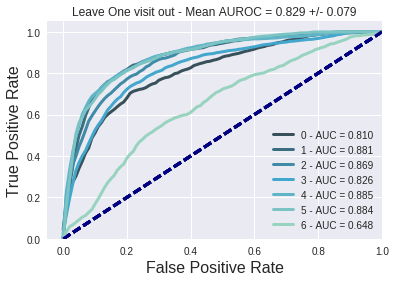

In [239]:
#using 3 sensors (hand, sacrum, thigh)
# current_palette=sns.color_palette("Paired", len(aurocall))
# current_palette=sns.color_palette("Reds", len(aurocall))
current_palette=sns.color_palette("GnBu_d", len(aurocall))

for v in range(len(aurocall)):
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

In [240]:
Results = {'f1':f1all, 'recall':rec_all, 'spec':spec_all, 'auroc':aurocall, 'auprc':auprcall, 'rec_task':rec_task,
          'TPR':tpr_all,'FPR':fpr_all}
np.save('./Results/Brady_LOVO_3Sensors.npy',Results)

In [241]:
Results=np.load('./Results/Brady_LOVO_3Sensors.npy')

In [242]:
rec_task = Results.item()['rec_task']

In [243]:
#add names to task recall dataframe
taskcodes = le.fit_transform(np.unique(data.Task))
tasknames = le.inverse_transform(np.unique(task_subj))
rec_task.index = tasknames

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [244]:
rec_task

,0,1,2,3,4,5,6
Motor #10: Drinking Water,0.566832,0.897778,0.936782,0.679537,0.862944,0.878505,0.800000
Motor #11: Organizing Folder,0.577947,0.781609,0.786517,0.644279,0.805031,0.664596,0.692308
Motor #12: Folding Towels,0.575099,0.750903,0.830579,0.639474,0.827839,0.859259,0.570922
Motor #2: Walking,0.775701,0.887701,0.929825,0.762963,0.886256,0.920792,0.744565
Motor #3: Walking while Counting,0.887240,0.902703,0.886700,0.792517,0.897638,0.957746,0.730769
Motor #4: Finger to Nose,0.567010,0.873239,0.915493,0.585366,0.740000,0.887500,0.786325
Motor #5: Alternating Hand Movements,0.788546,0.931034,0.877863,0.924528,0.784722,0.795455,0.748031
Motor #7: Drawing on Paper,0.730964,0.860294,0.890909,0.586957,0.802326,0.640845,0.384615
Motor #8: Typing on a Computer,0.472941,0.800738,0.747440,0.661376,0.851590,0.681275,0.453744
Motor #9: Nuts and Bolts,0.627397,0.870629,0.812000,0.701657,0.855172,0.714724,0.748837


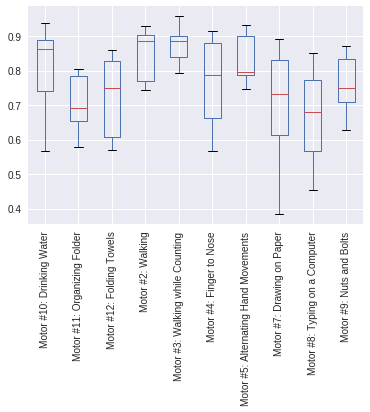

In [245]:
rec_task.T.plot(kind='box')
ax=plt.xticks(rotation=90)

### LOSO

reshaping data for different models ...
CNN
X_train = 
(10819, 1, 313, 30)
model training ... - eval on subj [0]
f1_test=0.392, Prec=0.435, Rec=0.357, Spec=0.808, auprc=0.403, auroc=0.596
[[383  91]
 [126  70]]
reshaping data for different models ...
CNN
X_train = 
(10737, 1, 313, 30)
model training ... - eval on subj [1]
f1_test=0.468, Prec=0.973, Rec=0.308, Spec=0.867, auprc=0.971, auroc=0.735
[[ 39   6]
 [489 218]]
reshaping data for different models ...
CNN
X_train = 
(10692, 1, 313, 30)
model training ... - eval on subj [2]
f1_test=0.616, Prec=0.916, Rec=0.464, Spec=0.946, auprc=0.834, auroc=0.750
[[330  19]
 [240 208]]
reshaping data for different models ...
CNN
X_train = 
(10651, 1, 313, 30)
model training ... - eval on subj [3]
f1_test=0.626, Prec=0.531, Rec=0.761, Spec=0.758, auprc=0.596, auroc=0.819
[[467 149]
 [ 53 169]]
reshaping data for different models ...
CNN
X_train = 
(11383, 1, 313, 30)
model training ... - eval on subj [4]
f1_test=0.578, Prec=0.722, Rec=0.481, Spec=

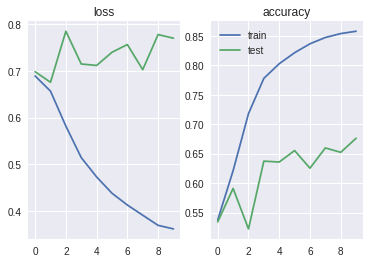

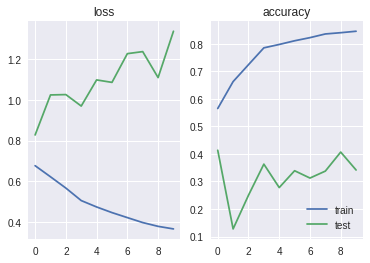

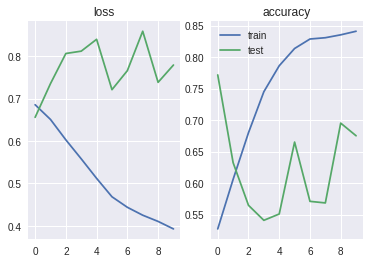

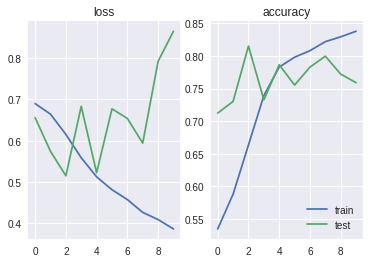

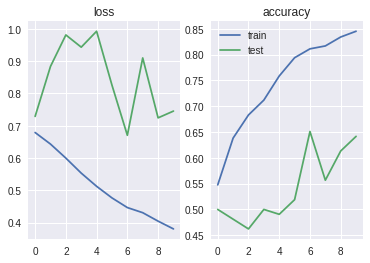

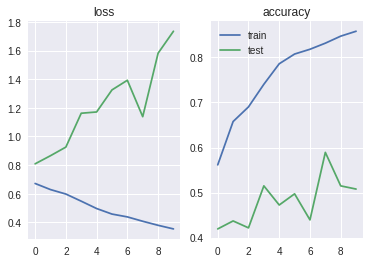

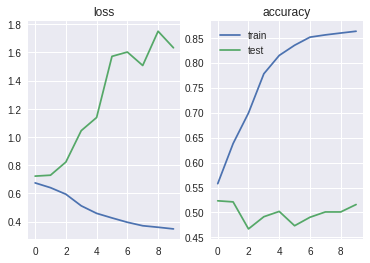

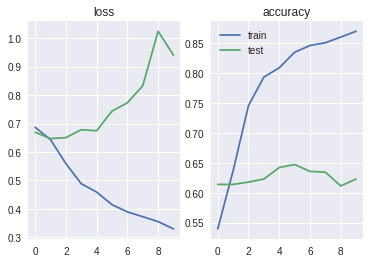

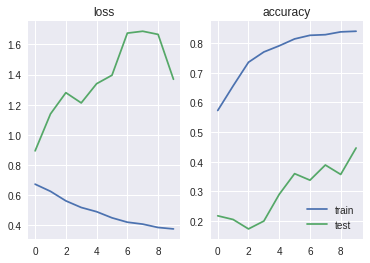

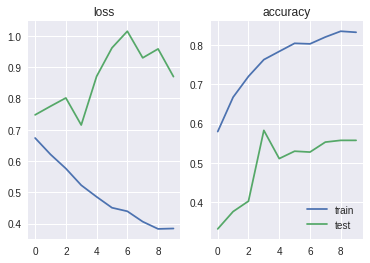

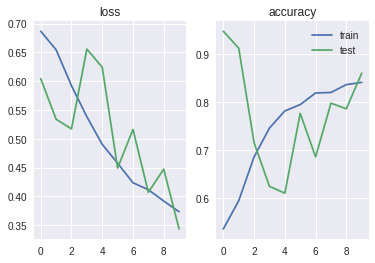

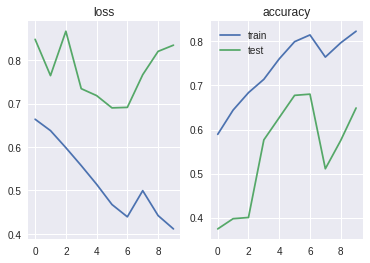

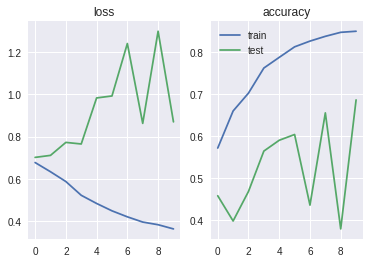

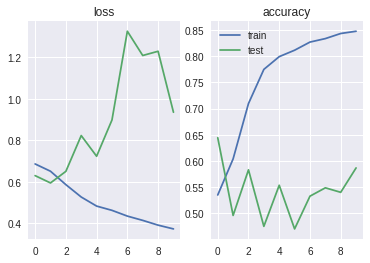

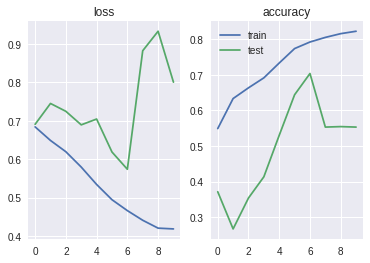

In [84]:
#specify loso or lovo cv
# lovar = visit.copy()
lovar = subj.copy()

#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, lovar):
    
    RecS=[] #store recall per task
    
    current_visit = np.unique(lovar[test_index])
    task_subj = task[test_index] #tasks for current visit

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on subj %s'%current_visit)
    epochs = 10
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid),verbose=0)
    f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    rec_all.append(Rec)
    spec_all.append(Spec)
    fpr_all.append(fpr); tpr_all.append(tpr)
    
    #store recall per task
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_valid = np.argmax(y_valid,axis=1)
    for t in np.unique(task_subj):
        
        ind_task = task_subj==t
        ypred_s = y_pred[ind_task]
        ytrue_s = y_valid[ind_task]
        TP=sum(ypred_s[ytrue_s==1])
        P = sum(ytrue_s == 1)
        RecS.append(TP/P)
        
    rec_task[current_visit[0]]=np.asarray(RecS)


        

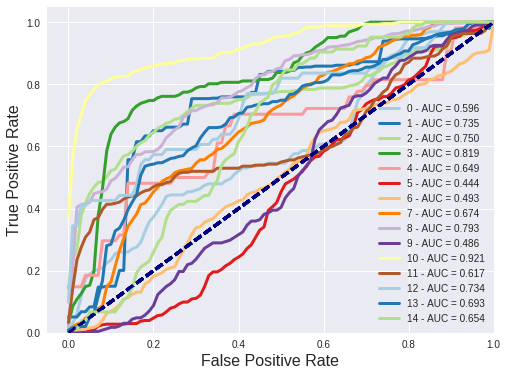

In [93]:
#using all sensors
current_palette=sns.color_palette("Paired", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(aurocall)):
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None,plotname=v,col=current_palette[v])

In [59]:
#save current model weights
model.save('./Models/model_brady.h5')

Batch norm does not improve results nor stabilize performance on valid set

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


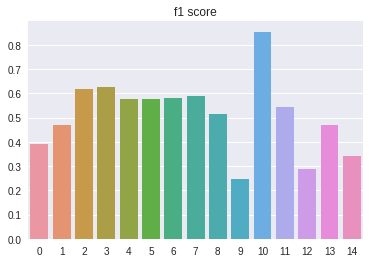

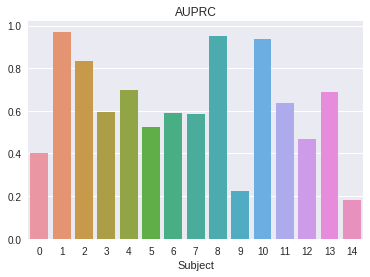

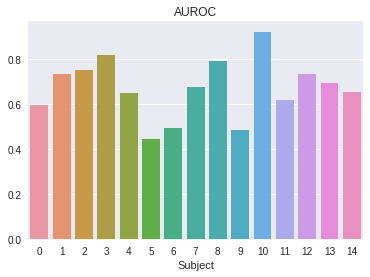

In [89]:
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=f1all)
plt.title('f1 score')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.title('AUROC')
plt.xlabel('Subject')

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


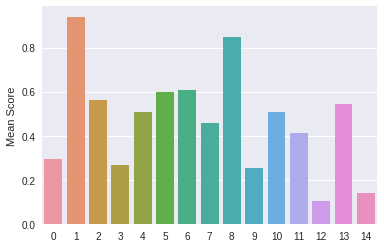

In [96]:
meanscore=[]
for train_index, test_index in loso.split(X, y, subj):
    meanscore.append(sum(y[test_index]==1)/len(y[test_index]))        
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=meanscore)
plt.ylabel('Mean Score')

from scipy.stats import pearsonr

(0.11220101331703312, 0.6905457705767479)


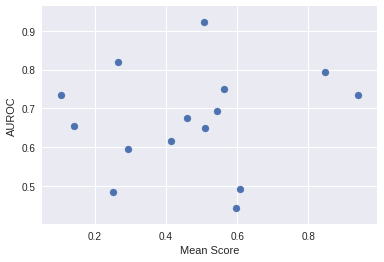

In [99]:
plt.scatter(x=meanscore,y=aurocall)
print(pearsonr(meanscore,aurocall))
plt.xlabel('Mean Score')
plt.ylabel('AUROC')

In [101]:
taskcodes = le.fit_transform(data.Task)
taskcodes = np.unique(taskcodes)
tasknames = le.inverse_transform(taskcodes)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [102]:
print(list(zip(taskcodes,tasknames)))

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #6: Sit to Stand'), (6, 'Motor #7: Drawing on Paper'), (7, 'Motor #8: Typing on a Computer'), (8, 'Motor #9: Nuts and Bolts')]


In [103]:
l = list(zip(taskcodes,tasknames))

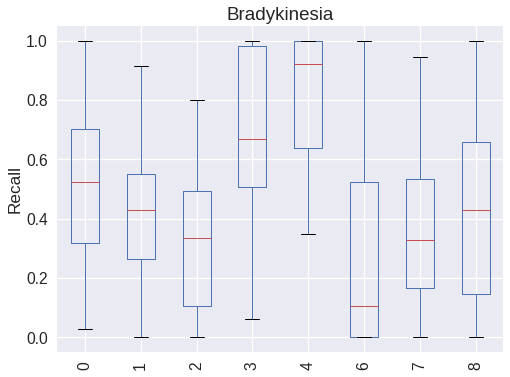

In [105]:
sns.set_context('talk',font_scale=1.2)
plt.figure(figsize=(8,6))
rec_task.T.boxplot(rot=90)
plt.ylabel('Recall')
plt.title('Bradykinesia')

### Leave one visit out

In [205]:
Data_brady['sensor']

Index(['anterior_thigh__accel', 'anterior_thigh__gyro',
       'distal_lateral_shank__accel', 'distal_lateral_shank__gyro',
       'dorsal_hand__accel', 'dorsal_hand__gyro', 'flexor_digitorum__accel',
       'medial_chest_accel', 'sacrum_accel', 'sacrum_gyro'],
      dtype='object')

In [233]:
# X = Data_brady['X'][:,:,12:18]
# fig=plt.figure()
# fig.add_subplot(121)
# plt.plot(xnew[0][:,:3])
# fig.add_subplot(122)
# plt.plot(xnew[0][:,3:])


reshaping data for different models ...
CNN
X_train = 
(9718, 1, 313, 6)
model training ... - eval on visit [0]
f1_test=0.746, Prec=0.833, Rec=0.675, Spec=0.773, auprc=0.853, auroc=0.797
[[510 150]
 [361 750]]
reshaping data for different models ...
CNN
X_train = 
(9864, 1, 313, 6)
model training ... - eval on visit [1]
f1_test=0.709, Prec=0.685, Rec=0.734, Spec=0.722, auprc=0.795, auroc=0.801
[[643 248]
 [195 539]]
reshaping data for different models ...
CNN
X_train = 
(9933, 1, 313, 6)
model training ... - eval on visit [2]
f1_test=0.630, Prec=0.667, Rec=0.597, Spec=0.784, auprc=0.740, auroc=0.791
[[706 195]
 [264 391]]
reshaping data for different models ...
CNN
X_train = 
(9831, 1, 313, 6)
model training ... - eval on visit [3]
f1_test=0.718, Prec=0.755, Rec=0.683, Spec=0.765, auprc=0.831, auroc=0.819
[[616 189]
 [270 583]]
reshaping data for different models ...
CNN
X_train = 
(9851, 1, 313, 6)
model training ... - eval on visit [4]
f1_test=0.692, Prec=0.647, Rec=0.744, Spec=0.668

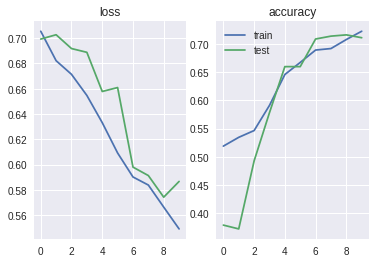

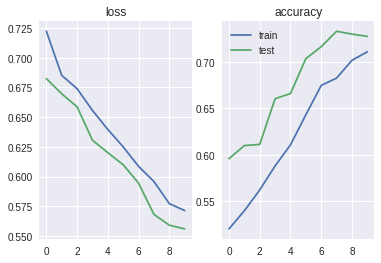

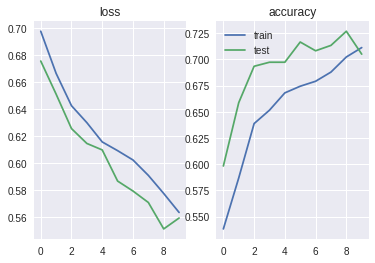

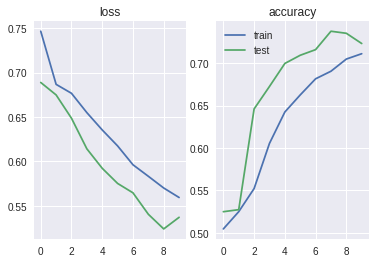

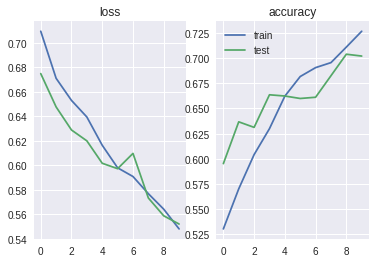

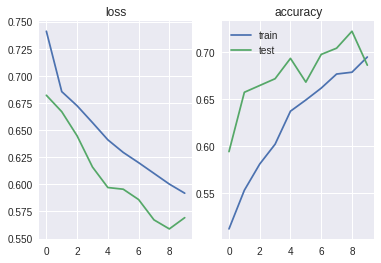

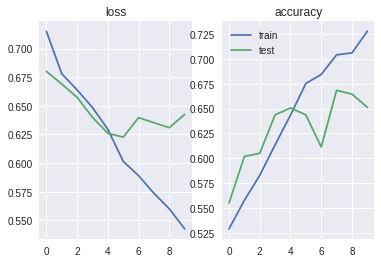

In [231]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, visit):
    
    RecS=[] #store recall per task
    
    current_visit = np.unique(visit[test_index])
    task_subj = task[test_index] #tasks for current visit

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on visit %s'%current_visit)
    epochs = 10
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid),verbose=0)
    f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    rec_all.append(Rec)
    spec_all.append(Spec)
    fpr_all.append(fpr); tpr_all.append(tpr)
    
    #store recall per task
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_valid = np.argmax(y_valid,axis=1)
    for t in np.unique(task_subj):
        
        ind_task = task_subj==t
        ypred_s = y_pred[ind_task]
        ytrue_s = y_valid[ind_task]
        TP=sum(ypred_s[ytrue_s==1])
        P = sum(ytrue_s == 1)
        RecS.append(TP/P)
        
    rec_task[current_visit[0]]=np.asarray(RecS)


        

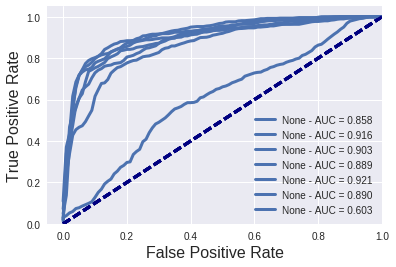

In [200]:
#using all sensors
for v in range(len(aurocall)):
    
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None)

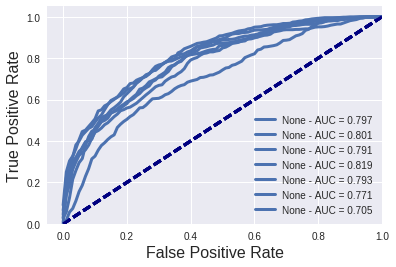

In [232]:
#using only hand sensors
for v in range(len(aurocall)):
    
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None)

In [40]:
#save current model weights
model.save('./Models/model_brady_LOVO_2.h5')

In [41]:
Results = {'f1':f1all, 'recall':rec_all, 'spec':spec_all, 'auroc':aurocall, 'auprc':auprcall, 'rec_task':rec_task,
          'TPR':tpr_all,'FPR':fpr_all}
np.save('./Results/Brady_results_2.npy',Results)

In [32]:
Results=np.load('./Results/Brady_results.npy')

In [42]:
t = np.unique(task)
rec_task = Results.item()['rec_task']
rec_task.index=tasknames[t]
aurocall = Results.item()['auroc']

In [34]:
print(np.mean(Results.item()['recall']),np.std(Results.item()['recall']))

0.7947170193095848 0.05689801464469766


In [35]:
print(np.mean(Results.item()['spec']),np.std(Results.item()['spec']))

0.6664836189367006 0.0714032707408531


In [36]:
print(np.mean(Results.item()['auroc']),np.std(Results.item()['auroc']))

0.8103757344860568 0.04669995652023568


/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


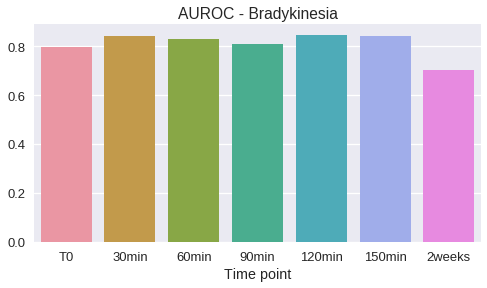

In [37]:
plt.figure(figsize=(8,4))
sns.set_context('talk')
ax=sns.barplot(x=np.arange(len(np.unique(visit))),y=aurocall)
plt.title('AUROC - Bradykinesia')
plt.xlabel('Time point')
ax=plt.xticks(np.arange(7),['T0','30min','60min','90min','120min','150min','2weeks'])

In [38]:
np.median(aurocall)

0.8284381382207437

In [39]:
le = LabelEncoder()
taskcodes = le.fit_transform(data.Task)
taskcodes = np.unique(taskcodes)
tasknames = le.inverse_transform(taskcodes)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [40]:
print(list(zip(taskcodes,tasknames)))

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


In [22]:
l = list(zip(taskcodes,tasknames))

In [43]:
rec_task

,0,1,2,3,4,5,6
Motor #10: Drinking Water,0.860714,0.805755,0.914894,0.787500,0.827869,0.864286,0.700000
Motor #11: Organizing Folder,0.706522,0.558333,0.791489,0.643110,0.609244,0.582645,0.623932
Motor #12: Folding Towels,0.582353,0.693548,0.843373,0.738318,0.585635,0.789744,0.663121
Motor #2: Walking,0.847059,0.860465,0.955975,0.852941,0.967949,0.925714,0.668478
Motor #3: Walking while Counting,0.851562,0.853801,0.971751,0.867347,0.960199,0.955801,0.768116
Motor #4: Finger to Nose,0.770833,0.770492,0.956522,0.783333,0.717949,0.928571,0.433333
Motor #5: Alternating Hand Movements,0.770349,0.849057,0.838384,0.888430,0.978947,0.866071,0.791667
Motor #7: Drawing on Paper,0.885350,0.804124,0.837209,0.883721,0.728972,1.000000,0.800000
Motor #8: Typing on a Computer,0.946768,0.593607,0.860465,0.725000,0.795122,0.890173,0.541850
Motor #9: Nuts and Bolts,0.862661,0.917476,0.885714,0.788288,0.861244,0.906250,0.859813


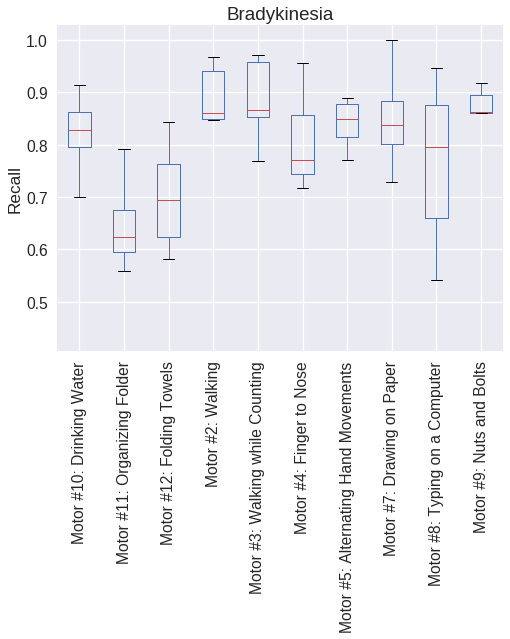

In [44]:
sns.set_context('talk',font_scale=1.2)
plt.figure(figsize=(8,6))
rec_task.T.boxplot(rot=90)
plt.ylabel('Recall')
plt.title('Bradykinesia')

In [88]:
from scipy.stats import wilcoxon

In [89]:
rec_task.T.median()

Motor #10: Drinking Water               0.827869
Motor #11: Organizing Folder            0.623932
Motor #12: Folding Towels               0.693548
Motor #2: Walking                       0.860465
Motor #3: Walking while Counting        0.867347
Motor #4: Finger to Nose                0.770833
Motor #5: Alternating Hand Movements    0.849057
Motor #7: Drawing on Paper              0.837209
Motor #8: Typing on a Computer          0.795122
Motor #9: Nuts and Bolts                0.862661
dtype: float64

## Tremor

In [45]:
X = np.load('Trainclips.npy')
y = scores_tremor.values
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)
print(X.shape)
print(y.shape)

(27546, 313, 6)
(27546,)


In [46]:
#remove rows (tasks) for which bradykinesia scores do not exists
indok = np.where(~np.isnan(y))[0]
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]

In [47]:
np.std(y)

0.6294887086055725

In [97]:
np.unique(task)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [98]:
print(X.shape)
print(y.shape)
print(task.shape)
print(visit.shape)
print(subj.shape)

(27273, 313, 6)
(27273,)
(27273,)
(27273,)
(27273,)


In [99]:
#binarize labels
y[y>0] = 1

reshaping data for different models ...
CNN
X_train = 
(23063, 1, 313, 6)
model training ... - eval on visit [0]
f1_test=0.582, Prec=0.866, Rec=0.439, Spec=0.961, auprc=0.760, auroc=0.816
[[2567  104]
 [ 864  675]]
reshaping data for different models ...
CNN
X_train = 
(23417, 1, 313, 6)
model training ... - eval on visit [1]
f1_test=0.666, Prec=0.684, Rec=0.649, Spec=0.934, auprc=0.742, auroc=0.904
[[2955  208]
 [ 243  450]]
reshaping data for different models ...
CNN
X_train = 
(23442, 1, 313, 6)
model training ... - eval on visit [2]
f1_test=0.691, Prec=0.648, Rec=0.742, Spec=0.919, auprc=0.751, auroc=0.929
[[2934  258]
 [ 165  474]]
reshaping data for different models ...
CNN
X_train = 
(23376, 1, 313, 6)
model training ... - eval on visit [3]
f1_test=0.579, Prec=0.785, Rec=0.459, Spec=0.956, auprc=0.711, auroc=0.859
[[2770  126]
 [ 542  459]]
reshaping data for different models ...
CNN
X_train = 
(23458, 1, 313, 6)
model training ... - eval on visit [4]
f1_test=0.650, Prec=0.810, 

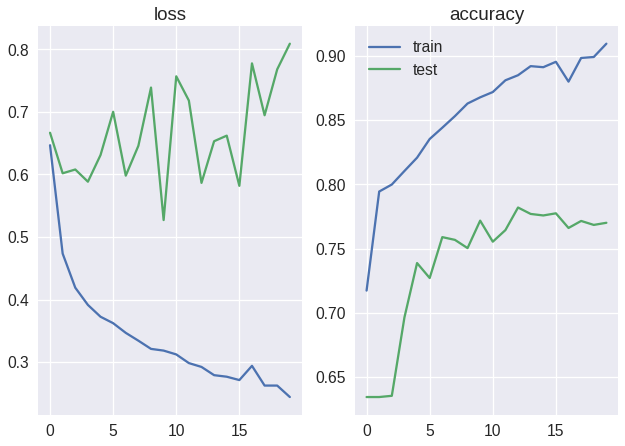

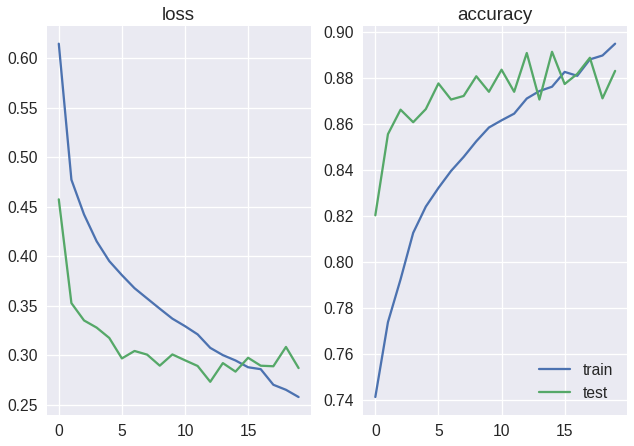

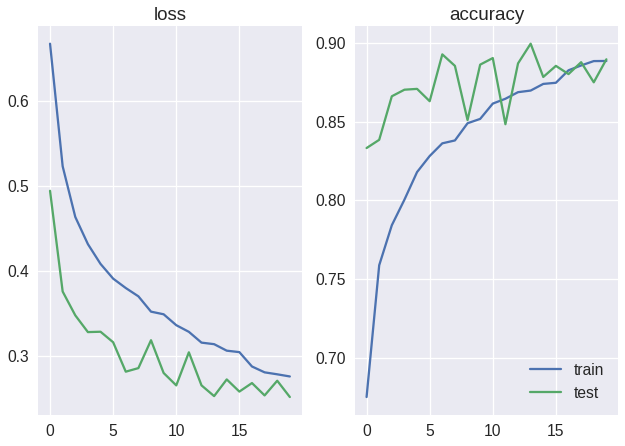

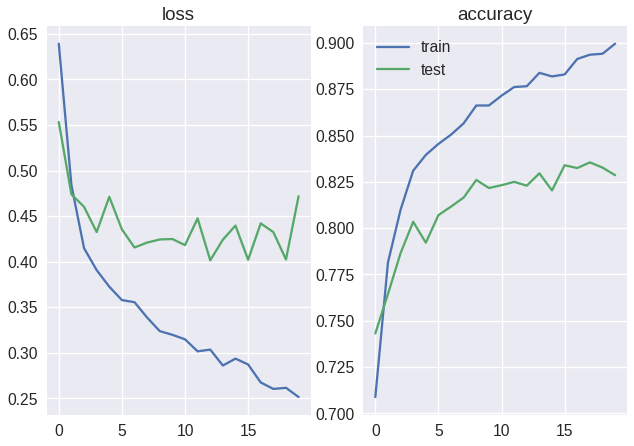

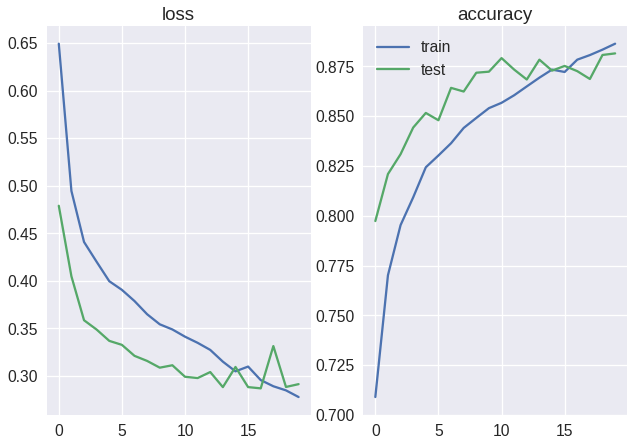

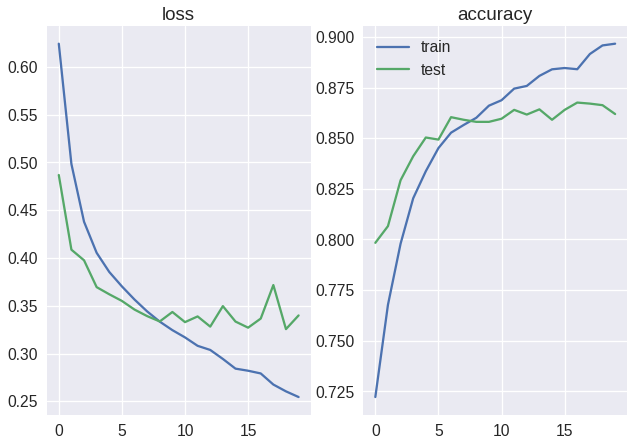

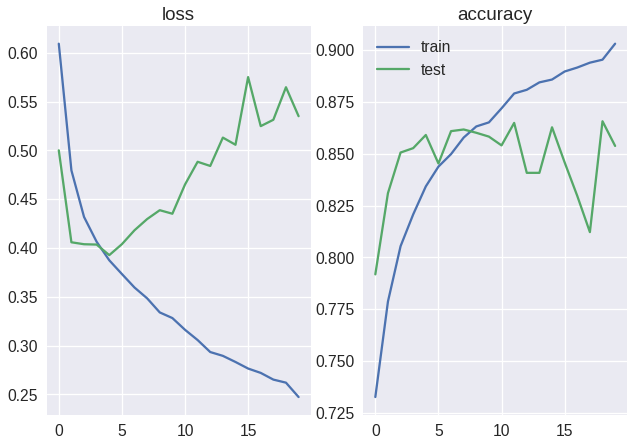

In [100]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]
for train_index, test_index in loso.split(X, y, visit):
    
    RecS=[] #store recall per task
    
    current_visit = np.unique(visit[test_index])
    task_subj = task[test_index] #tasks for current visit

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on visit %s'%current_visit)
    epochs = 20
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid),verbose=0)
    f1,Rec,Spec,auprc,auroc=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    rec_all.append(Rec)
    spec_all.append(Spec)
    
    #store recall per task
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_valid = np.argmax(y_valid,axis=1)
    for t in np.unique(task_subj):
        
        ind_task = task_subj==t
        ypred_s = y_pred[ind_task]
        ytrue_s = y_valid[ind_task]
        TP=sum(ypred_s[ytrue_s==1])
        P = sum(ytrue_s == 1)
        RecS.append(TP/P)
        
    rec_task[current_visit[0]]=np.asarray(RecS)


        

In [51]:
#save current model weights
model.save('./Models/model_tremor_LOVO.h5')

In [101]:
Results = {'f1':f1all, 'recall':rec_all, 'spec':spec_all, 'auroc':aurocall, 'auprc':auprcall, 'rec_task':rec_task}
np.save('./Results/Tremor_results.npy',Results)

In [48]:
Results=np.load('./Results/Tremor_results.npy')
rec_task = Results.item()['rec_task']

In [49]:
print(np.mean(Results.item()['recall']),np.std(Results.item()['recall']))

0.5928644196075092 0.10608595712210471


In [50]:
print(np.mean(Results.item()['spec']),np.std(Results.item()['spec']))

0.9366345598842108 0.023484903557563386


In [51]:
print(np.mean(Results.item()['auroc']),np.std(Results.item()['auroc']))

0.876448770271889 0.040830318954939236


/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


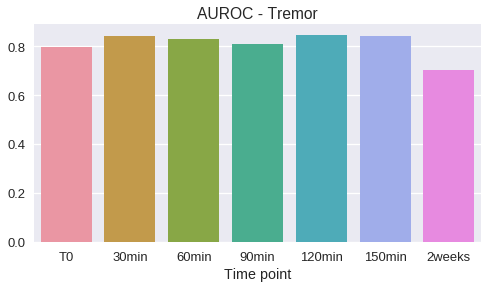

In [52]:
plt.figure(figsize=(8,4))
sns.set_context('talk')
ax=sns.barplot(x=np.arange(len(np.unique(visit))),y=aurocall)
plt.title('AUROC - Tremor')
plt.xlabel('Time point')
ax=plt.xticks(np.arange(7),['T0','30min','60min','90min','120min','150min','2weeks'])

In [54]:
rec_task

,0,1,2,3,4,5,6
Motor #10: Drinking Water,0.336735,0.445946,0.703125,0.266129,0.253012,0.351648,0.591837
Motor #11: Organizing Folder,0.282258,0.492754,0.455556,0.463768,0.301724,0.468750,0.615385
Motor #12: Folding Towels,0.444444,0.686957,0.551724,0.517857,0.517241,0.750000,0.793750
Motor #2: Walking,0.581818,0.692308,0.615385,0.923077,0.750000,0.714286,0.080000
Motor #3: Walking while Counting,0.688889,0.733333,0.769231,0.592593,0.631579,0.705882,0.000000
Motor #4: Finger to Nose,0.619048,0.820513,0.867647,0.546392,0.793651,0.753247,0.593023
Motor #5: Alternating Hand Movements,0.520000,0.653333,0.959459,0.648649,0.841667,0.818841,0.691489
Motor #6: Sit to Stand,0.400000,NaN,0.333333,0.187500,NaN,NaN,NaN
Motor #7: Drawing on Paper,0.584906,0.613636,0.595238,0.094340,0.607143,0.743590,0.787879
Motor #8: Typing on a Computer,0.421053,0.701754,0.954545,0.391753,0.482353,0.540230,0.734940


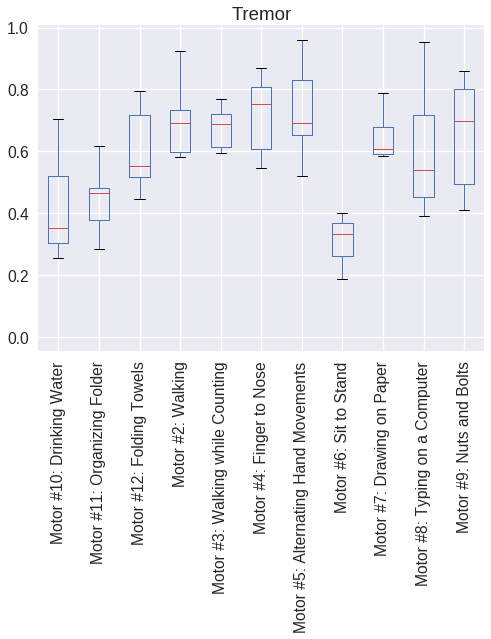

In [76]:
sns.set_context('talk',font_scale=1.2)
plt.figure(figsize=(8,6))
rec_task.index = tasknames
rec_task.T.boxplot()
ax=plt.xticks(rotation=90)
plt.title('Tremor')

In [55]:
from scipy.stats import ranksums

In [69]:
x = rec_task.iloc[3,:]
y = rec_task.iloc[5,:]

In [75]:
for i in range(len(rec_task)):
    print(rec_task.index[i],np.median(rec_task.iloc[i,:]))
    x = rec_task.iloc[i,:]
    print(ranksums(x,y))

Motor #10: Drinking Water 0.3516483516483517
RanksumsResult(statistic=-2.6193939164997535, pvalue=0.00880861651937405)
Motor #11: Organizing Folder 0.463768115942029
RanksumsResult(statistic=-2.8749445424997293, pvalue=0.004040984683985582)
Motor #12: Folding Towels 0.5517241379310345
RanksumsResult(statistic=-1.5971914124998496, pvalue=0.11022304635486535)
Motor #2: Walking 0.6923076923076923
RanksumsResult(statistic=-0.7027642214999339, pvalue=0.48220269762779056)
Motor #3: Walking while Counting 0.6888888888888889
RanksumsResult(statistic=-0.9583148474999098, pvalue=0.33790401910300505)
Motor #4: Finger to Nose 0.7532467532467533
RanksumsResult(statistic=0.0, pvalue=1.0)
Motor #5: Alternating Hand Movements 0.6914893617021277
RanksumsResult(statistic=0.3194382824999699, pvalue=0.7493941849625707)
Motor #6: Sit to Stand nan
RanksumsResult(statistic=0.4472135954999579, pvalue=0.6547208460185769)
Motor #7: Drawing on Paper 0.6071428571428571
RanksumsResult(statistic=-1.3416407864998738

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [32]:
rec_task.T.median()

Motor #10: Drinking Water               0.351648
Motor #11: Organizing Folder            0.463768
Motor #12: Folding Towels               0.551724
Motor #2: Walking                       0.692308
Motor #3: Walking while Counting        0.688889
Motor #4: Finger to Nose                0.753247
Motor #5: Alternating Hand Movements    0.691489
Motor #6: Sit to Stand                  0.333333
Motor #7: Drawing on Paper              0.607143
Motor #8: Typing on a Computer          0.540230
Motor #9: Nuts and Bolts                0.698413
dtype: float64

In [111]:
print(list(zip(taskcodes,tasknames)))

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


Include personal data

reshaping data for different models ...
CNN
X_train = 
(24753, 1, 313, 6)
model training ... - eval on subj [0]
f1_test=0.384, Prec=0.307, Rec=0.510, Spec=0.646, auprc=0.386, auroc=0.586
[[714 392]
 [167 174]]
reshaping data for different models ...
CNN
X_train = 
(24541, 1, 313, 6)
model training ... - eval on subj [1]
f1_test=0.807, Prec=0.950, Rec=0.701, Spec=0.647, auprc=0.923, auroc=0.654
[[ 101   55]
 [ 449 1054]]
reshaping data for different models ...
CNN
X_train = 
(24678, 1, 313, 6)
model training ... - eval on subj [2]
f1_test=0.678, Prec=0.716, Rec=0.643, Spec=0.676, auprc=0.773, auroc=0.708
[[453 217]
 [304 548]]
reshaping data for different models ...
CNN
X_train = 
(24614, 1, 313, 6)
model training ... - eval on subj [3]
f1_test=0.621, Prec=0.463, Rec=0.942, Spec=0.594, auprc=0.757, auroc=0.885
[[687 469]
 [ 25 405]]
reshaping data for different models ...
CNN
X_train = 
(24683, 1, 313, 6)
model training ... - eval on subj [4]
f1_test=0.541, Prec=0.666, Rec=0.456, Spec=0

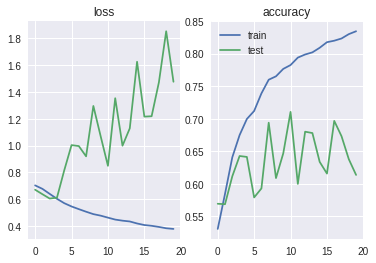

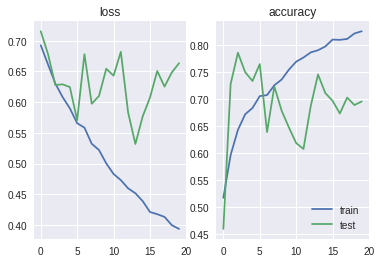

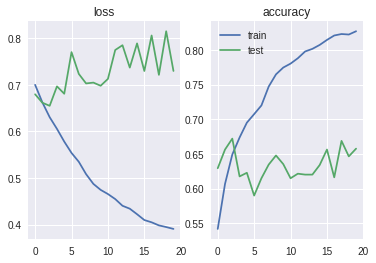

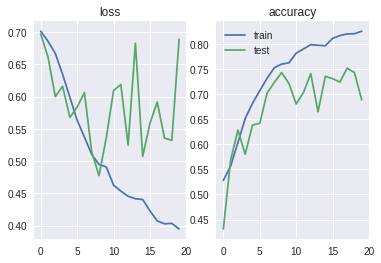

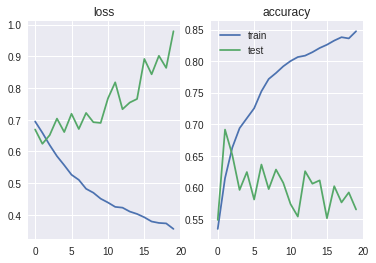

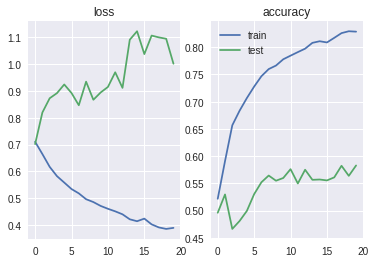

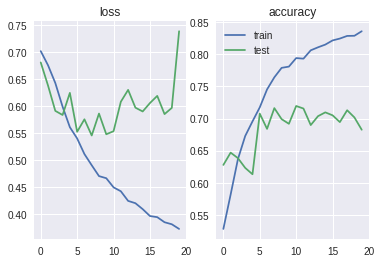

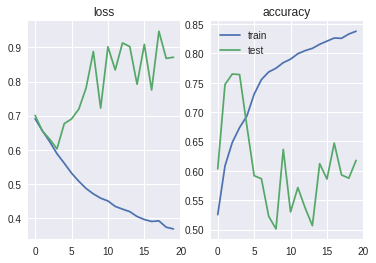

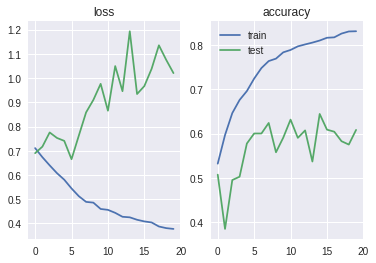

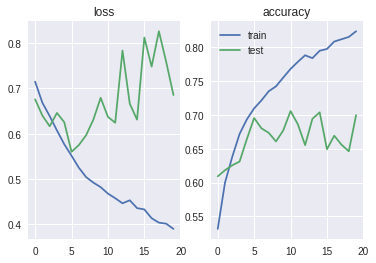

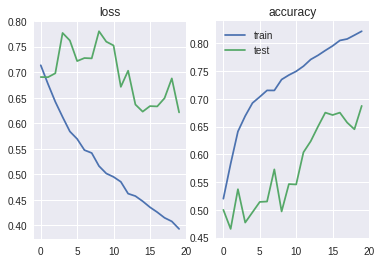

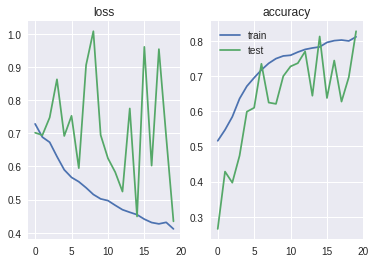

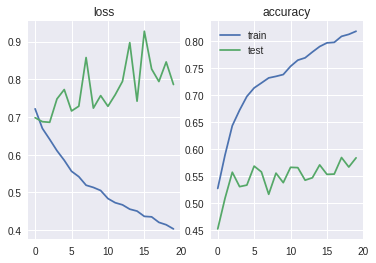

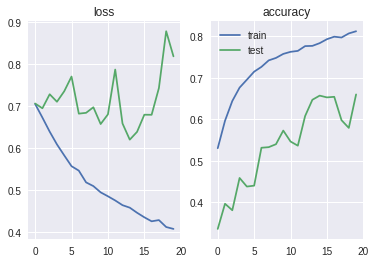

In [127]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]
for train_index, test_index in loso.split(X, y, subj):
    
    RecS=[] #store recall per task
    
    current_subj = np.unique(subj[test_index])
    task_subj = task[test_index] #tasks for current subj
    visit_subj = visit[test_index] #visits for current subj

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  
    
    #include data from current patient visit 0 in training
    X_train=np.concatenate((X_train,X_valid[visit_subj==0]),axis=0)
    y_train=np.concatenate((y_train,y_valid[visit_subj==0]))
    X_valid=X_valid[visit_subj!=0]
    y_valid=y_valid[visit_subj!=0]

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on subj %s'%current_subj)
    epochs = 20
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid),verbose=0)
    f1,Rec,Spec,auprc,auroc=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)

        

In [128]:
#save current model weights
model.save('./Models/modelpers_brady.h5')

0.6958418591583018 0.05007712006393535


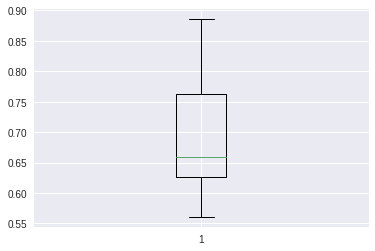

In [139]:
ax=plt.boxplot(aurocall)
print(np.mean(aurocall),1.96*np.std(aurocall)/np.sqrt(len(aurocall)))

0.635239094052561 0.11645612118108234


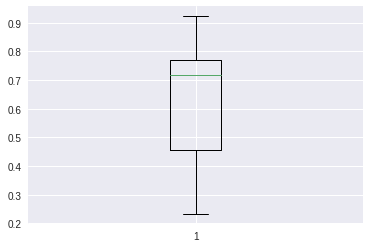

In [140]:
ax=plt.boxplot(auprcall)
print(np.mean(auprcall),1.96*np.std(auprcall)/np.sqrt(len(auprcall)))

Batch norm does not improve results nor stabilize performance on valid set

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


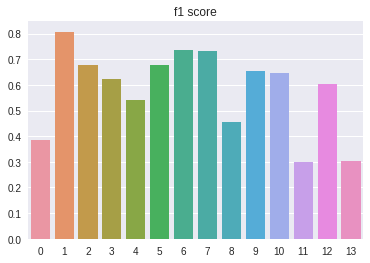

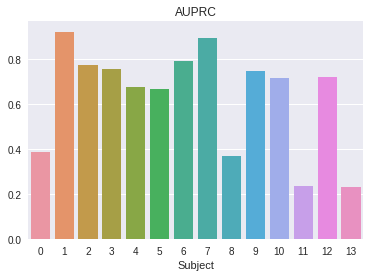

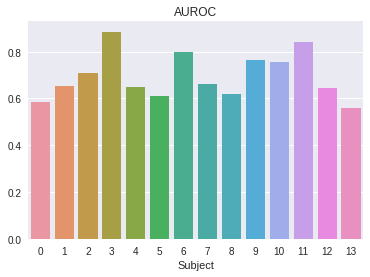

In [129]:
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=f1all)
plt.title('f1 score')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.title('AUROC')
plt.xlabel('Subject')

(-0.22730238141766096, 0.43450423609134803)


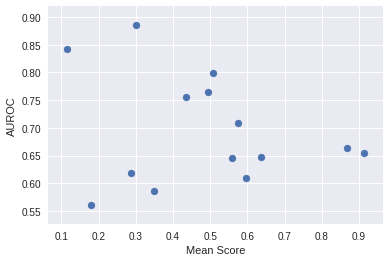

In [131]:
plt.scatter(x=P_ratio,y=aurocall)
print(pearsonr(P_ratio,aurocall))
plt.xlabel('Mean Score')
plt.ylabel('AUROC')